# APCOMP209A Project Milestone 5

# Table of Contents

1. [Motivation, Context and Problem Statement](#1.-Motivation-Context-and-Problem-Statement)

2. [Description of Data and EDA](#2.-Description-of-Data-and-EDA)  

   2.1 [Dataset Overview](#2.1-Dataset-Overview)  
   2.2 [Initial Data Analysis](#2.2-Initial-Data-Analysis)  
   2.3 [Data Preprocessing and Feature Engineering](#2.3-Data-Preprocessing-and-Feature-Engineering)  
       2.3.1 [Data Cleaning](#2.3.1-Data-Cleaning)  
       2.3.2 [Data Imputation](#2.3.2-Data-Imputation)  
       2.3.3 [FIFA Points Update](#2.3.3-FIFA-Points-Update)  

3. [Modeling Approach (Primary Approach)](#Modeling-Approach,-Primary-Approach)  

   3.1 [Understanding the FIFA World Cup Format](#3.1-Understanding-the-FIFA-World-Cup-Format)  
   3.2 [Modeling Strategy](#3.2-Modeling-Strategy)  
   3.3 [Train/Test Splits and Standardization](#3.3-Train/Test-Splits-and-Standardization)  
   3.4 [Fitting Model 1: OvR Logistic Regression for Round 1 (Group Stage)](#3.4-Fitting-Model-1-OvR-Logistic-Regression-for-Round-1-Group-Stage)  
   3.5 [Fitting Model 2: Simple Logistic Regression for Rounds 2-5 (Knockout Stages)](#3.5-Fitting-Model-2-Simple-Logistic-Regression-for-Rounds-2-5-Knockout-Stages)   

4. [Monte Carlo Simulation](#4-Monte-Carlo-Simulation)  

   4.1 [Creating Dataset for 2022 World Cup Teams](#4.1-Creating-Dataset-for-2022-World-Cup-Teams)  
   4.2 [Simulating the Group Stage](#4.2-Simulating-the-Group-Stage)  
   4.3 [Simulating the Knockout Stage](#4.3-Simulating-the-Knockout-Stage)  
   4.4 [Full Tournament Monte Carlo Simulation](#4.4-Full-Tournament-Monte-Carlo-Simulation)  

5. [Evaluating and Analyzing Results](#5-Evaluating-and-Analyzing-Results)  

   5.1 [Model 1 Accuracy and ROC AUC Scores](#5.1-Model-1-Accuracy-and-ROC-AUC-Scores)  
   5.2 [Model 2 Accuracy and F1 Score](#5.2-Model-2-Accuracy-and-F1-Score)  
   5.3 [Displaying Predicted Probabilities for Model 1](#5.3-Displaying-Predicted-Probabilities-for-Model-1)  
   5.4 [Displaying Predicted Probabilities for Model 2](#5.4-Displaying-Predicted-Probabilities-for-Model-2)  
   5.5 [Feature Importance and Coefficient Analysis for Model 1](#5.5-Feature-Importance-and-Coefficient-Analysis-for-Model-1)  
   5.6 [Feature Importance and Coefficient Analysis for Model 2](#5.6-Feature-Importance-and-Coefficient-Analysis-for-Model-2)  
   5.7 [Predicted World Cup Results from Monte Carlo Simulation in 4.3](#5.7-Predicted-World-Cup-Results-from-Monte-Carlo-Simulation-in-43)  
   5.8 [Comparison between our Predictions with Betting Odds, Fifa Predictions/Rankings, and Actual Results](#5.8-Comparison-between-our-Predictions-with-Betting-Odds,-Fifa-Predictions/Rankings,-and-Actual-Results)    

6. [ELO Methodology, Second Approach: An Alternative to Predicting the 2022 World Cup Outcomes](#6-ELO-Methodology,-Second-Approach:-An-Alternative-to-Predicting-the-2022-World-Cup-Outcomes)

   6.1 [Introduction to ELO Rating System](#6.1-Introduction-to-ELO-Rating-System)  
   6.2 [ELO Rating Simulation for World Cup 2022](#6.2-ELO-Rating-Simulation-for-World-Cup-2022)  
   6.3 [World Cup Group Stage Simulation Using ELO Ratings](#6.3-World-Cup-Group-Stage-Simulation-Using-ELO-Ratings)  
   6.4 [World Cup Knockout Stage Simulation Using ELO Ratings](#6.4-World-Cup-Knockout-Stage-Simulation-Using-ELO-Ratings)  
   6.5 [Monte Carlo Simulation using ELO Ratings](#6.5-Monte-Carlo-Simulation-using-ELO-Ratings)  
   6.6 [World Cup Simulation vs Betting Odds: KL Divergence Analysis](#6.6-World-Cup-Simulation-vs-Betting-Odds-KL-Divergence-Analysis)  

7. [Conclusion and Future Work](#7-Conclusion-and-Future-Work)


In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from collections import Counter, defaultdict
sys.path.append(os.getcwd())
from utils import *
from IPython.display import Image, display
np.random.seed(109)

# pandas tricks for better display
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

import warnings 
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Motivation, Context and Problem Statement

Since its inception, FIFA provides global rankings for Soccer/Football team's strengths, and it hads used a variety of metrics to varying degrees of success. From 1992 to 2006, FIFA rankings showed inaccurate team strength, noted by the ranking disparity in 2006 when looking at the World Cup performances. In 2006, FIFA changed their ranking system to a simpler model, using the performance of the team over four years instead of eight years, no longer incorporating whether the team was home or away, and removing the amount of points scored per game. Can we create a model that outperforms the FIFA rankings/predictions for the World Cup in 2022? More specifically,

**Can we create a model that accurately predicts pairwise probabilities for each 2022 World Cup team-pair and use these pairwise probabilities to accurately compute the probability of each team winning the 2022 World Cup via a Monte Carlo simulation in such a way that outperforms the FIFA rankings/predictions?**

### Project Flow Chart:

![](images/projectFlowChart.png)

As outlined in the project flowchart above, we begin our analysis with an exploration of the data through EDA and preprocessing. Following this, we implement our primary approach (Approach 1: Logistic Regression Models with Monte Carlo simulation) to predict the outcome of the 2022 World Cup Tournament. We then evaluate our results from approach 1 with betting odds, Fifa's predictions/rankings, and actual results. 

Finally, we implement a secondary approach (Approach 2: Elo Score Model with Monte Carlo Simulation) to predict the 2022 World Cup Tournament. This approach was implemented so as to assess alternative modeling techniques in predicting World Cup Tournament.

*Important to Note: The first approach (Logistic Regression Models with Monte Carlo Simulation) is the main/primary approach for this project.

# 2. Description of Data and EDA

## 2.1. Dataset Overview
We are using this dataset (international_matches.csv) from Kaggle:
https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022. It provides match data for
international soccer games that have been played since the 90s. Key features in the dataset
include:
- Basic Match Details: date, international teams involved, and their continents.
- Team Statistics: FIFA Rankings and total FIFA points for both teams.
- Match Outcomes: Home and away team scores, and shoot-out results if applicable.
- Team Positions Ratings on FIFA: Detailed statistics like goalkeeper scores, mean defense
scores, mean offense scores, and mean midfield scores for both teams, from the FIFA
video game. It is important to note that these ratings are the computed ratings before the
match starts.
The predictors we’ll most heavily rely on to predict the outcome of the 2022 World Cup
Championship are the goalkeeper scores, mean defense scores, mean offense scores, and mean
midfield scores. Additionally, we’ll rely on the FIFA Rankings/Points of each team to impute the
missing values of our interested predictors (via regression imputation) (More on this later).

Loading the raw dataset, and displaying the first few rows, summary statistics, and data structure to understand the dataset:

In [3]:
## Reading in Data
df = pd.read_csv('data/international_matches.csv')
worldCup = pd.read_csv('data/cleaned_dataset_world_cup.csv')
display(df.head(10))
display(df.describe())
display(df.info())

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,1,Friendly,Maceió,Brazil,False,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,0,FIFA World Cup qualification,Quito,Ecuador,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,0,Friendly,Conakry,Guinea,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1993-08-08,Peru,Colombia,South America,South America,70,19,0,0,0,1,FIFA World Cup qualification,Lima,Peru,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1993-08-08,Zimbabwe,Eswatini,Africa,Africa,50,102,0,0,2,0,Friendly,Harare,Zimbabwe,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1993-08-09,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,4,0,Friendly,Conakry,Guinea,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1993-08-11,Faroe Islands,Norway,Europe,Europe,111,9,0,0,0,7,Friendly,Toftir,Faroe Islands,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1993-08-11,Sweden,Switzerland,Europe,Europe,4,3,0,0,1,2,Friendly,Borås,Sweden,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
count,25733.000,25733.000,25733.000,25733.000,25733.000,25733.000,9525.000,9203.000,8855.000,9792.000,9248.000,8639.000,9572.000,9072.000
mean,76.938,79.614,300.629,293.241,1.604,1.067,74.757,74.079,74.865,75.892,75.840,74.488,75.586,75.305
std,51.919,52.873,489.908,480.175,1.617,1.255,8.422,8.479,6.059,6.208,6.071,6.017,6.209,6.179
min,1.000,1.000,0.000,0.000,0.000,0.000,47.000,47.000,52.800,53.300,54.200,52.800,53.300,54.200
25%,33.000,35.000,0.000,0.000,0.000,0.000,70.000,69.000,70.800,71.700,72.200,70.500,71.300,71.800
50%,70.000,72.000,0.000,0.000,1.000,1.000,75.000,74.000,75.000,75.700,76.000,74.500,75.300,75.800
75%,114.000,117.000,468.000,454.000,2.000,2.000,81.000,80.000,78.800,80.000,79.500,78.200,79.700,79.000
max,211.000,211.000,2164.000,2164.000,31.000,21.000,97.000,97.000,91.800,93.000,93.200,91.800,93.000,93.200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25733 entries, 0 to 25732
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           25733 non-null  object 
 1   home_team                      25733 non-null  object 
 2   away_team                      25733 non-null  object 
 3   home_team_continent            25733 non-null  object 
 4   away_team_continent            25733 non-null  object 
 5   home_team_fifa_rank            25733 non-null  int64  
 6   away_team_fifa_rank            25733 non-null  int64  
 7   home_team_total_fifa_points    25733 non-null  int64  
 8   away_team_total_fifa_points    25733 non-null  int64  
 9   home_team_score                25733 non-null  int64  
 10  away_team_score                25733 non-null  int64  
 11  tournament                     25733 non-null  object 
 12  city                           25733 non-null 

None

## 2.2. Initial Data Analysis

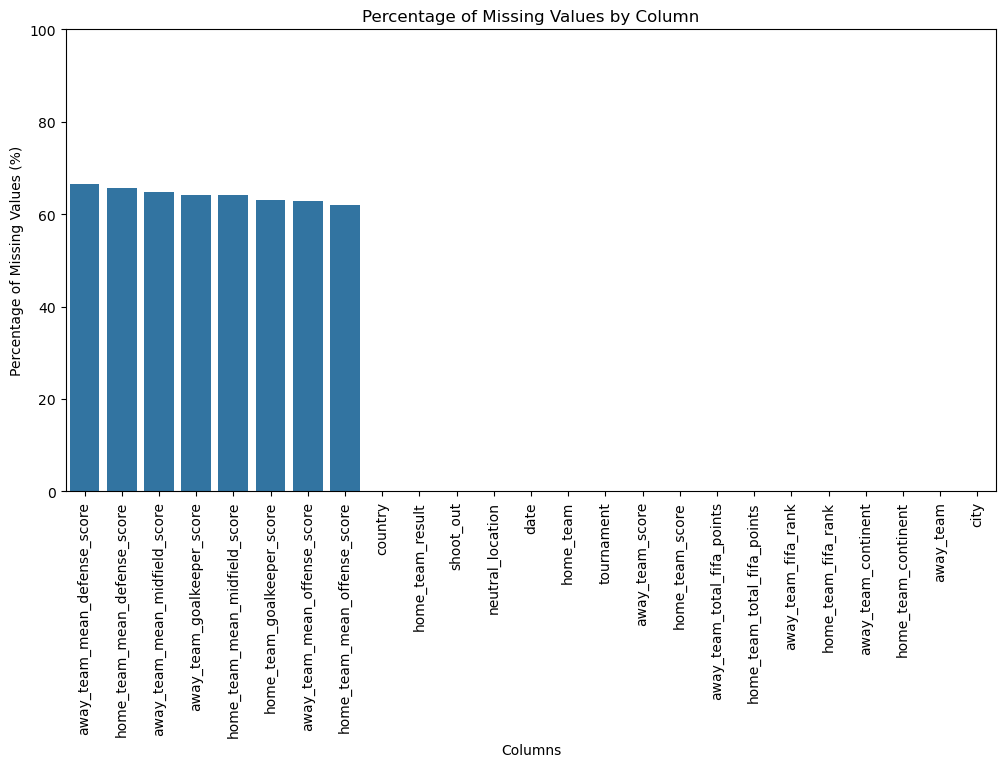

In [4]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)

# Plot the missing percentage by column as a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xticks(rotation=90)
plt.title("Percentage of Missing Values by Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of Missing Values (%)")
plt.ylim(0, 100)
plt.show()

As we can see, several columns have a high percentage of missing values, close to or above 60%. These columns include team performance metrics such as "home_team_mean_defense_score," "away_team_mean_goalkeeper_score," and others related to different team roles (defense, midfield, offense, goalkeeper).
The majority of other columns (like "country," "home_team," "away_team," and "date") have little to no missing data, which is a good sign for analysis.
We will try to analyze if there are any patterns correlated with the missingness of these features.

<Figure size 1400x800 with 0 Axes>

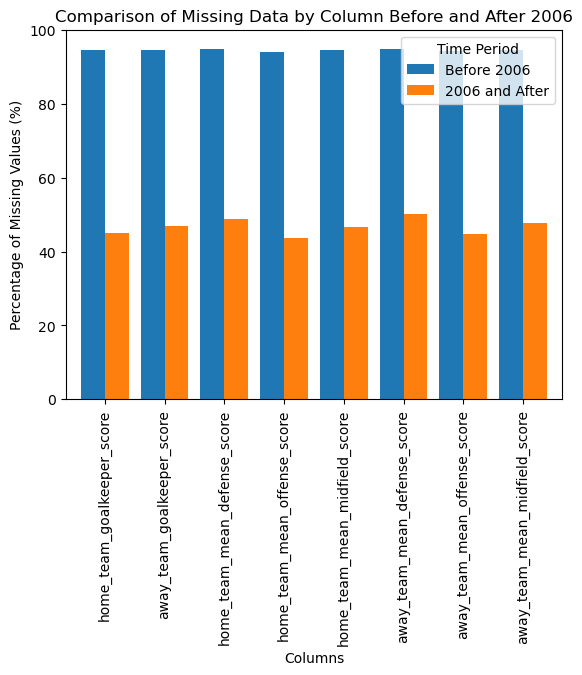

In [5]:
df['date'] = pd.to_datetime(df['date'])

# Split the data into two parts: before 2006 and from 2006 onward
data_before_2006 = df[df['date'] < '2006-01-01']
data_after_2006 = df[df['date'] >= '2006-01-01']

# Calculate the percentage of missing values for each part
missing_percentage_before_2006 = (data_before_2006.isnull().sum() / len(data_before_2006)) * 100
missing_percentage_after_2006 = (data_after_2006.isnull().sum() / len(data_after_2006)) * 100

# Filter to only include columns with missing data in either period
missing_columns = missing_percentage_before_2006[missing_percentage_before_2006 > 0].index.union(
    missing_percentage_after_2006[missing_percentage_after_2006 > 0].index
)
missing_percentage_before_2006 = missing_percentage_before_2006[missing_columns]
missing_percentage_after_2006 = missing_percentage_after_2006[missing_columns]

# Combine into a DataFrame for easier plotting
missing_comparison_time = pd.DataFrame({
    'Before 2006': missing_percentage_before_2006,
    '2006 and After': missing_percentage_after_2006
})

# Plot the comparison as a grouped bar plot
plt.figure(figsize=(14, 8))
missing_comparison_time.plot(kind='bar', width=0.8)
plt.title("Comparison of Missing Data by Column Before and After 2006")
plt.xlabel("Columns")
plt.ylabel("Percentage of Missing Values (%)")
plt.xticks(rotation=90)
plt.ylim(0, 100)  # Set y-axis to 100% for clarity
plt.legend(title="Time Period")
plt.show()

There is a notable decrease in missing values for the columns shown after 2006, indicating an improvement in data completeness over time.
The columns mainly represent team performance metrics, suggesting that data collection practices or available technology for tracking team statistics improved post-2006.

<Figure size 1200x600 with 0 Axes>

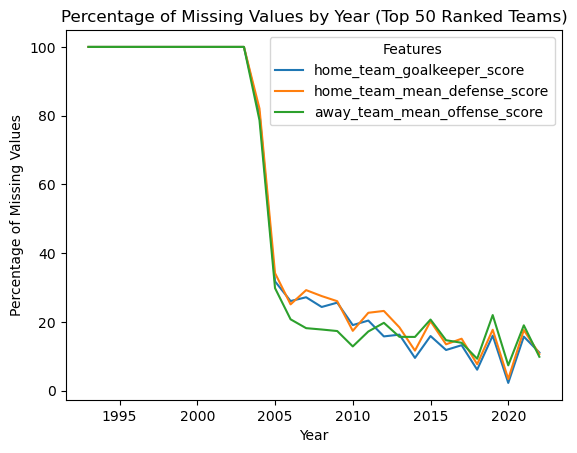

<Figure size 1200x600 with 0 Axes>

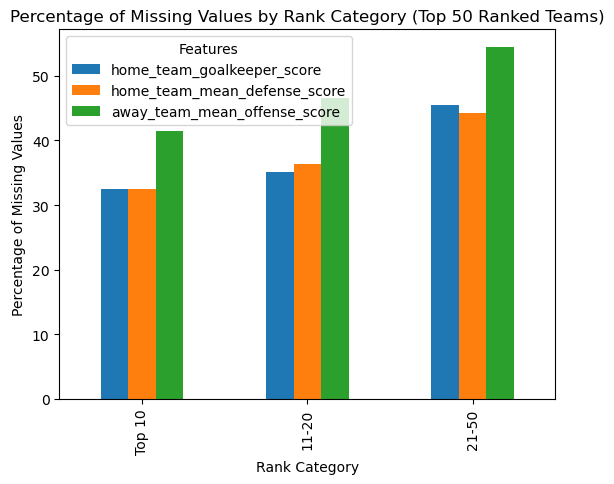

<Figure size 1200x600 with 0 Axes>

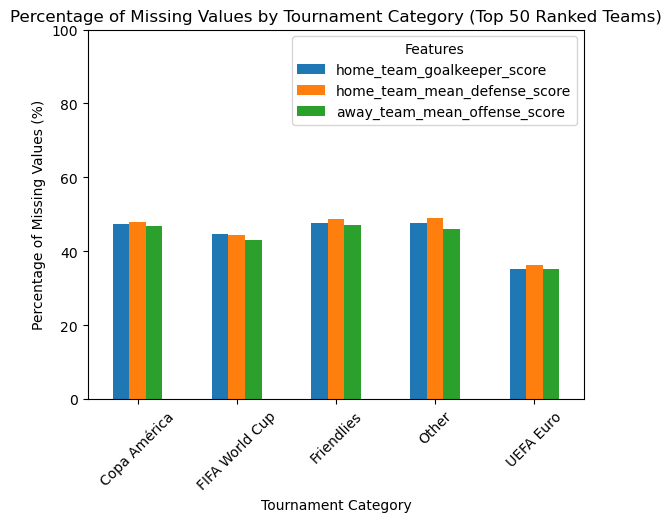

In [6]:
top_50_data = df.loc[(df['home_team_fifa_rank'] <= 50) | (df['away_team_fifa_rank'] <= 50)].copy()

# Create rank categories
top_50_data['rank_category'] = pd.cut(
    top_50_data['home_team_fifa_rank'],
    bins=[0, 10, 20, 50],
    labels=['Top 10', '11-20', '21-50']
)

# 1. Missingness by Year
top_50_data['year'] = top_50_data['date'].dt.year
missing_by_year = top_50_data.groupby('year').apply(lambda x: x.isnull().mean() * 100)

# Plot missingness by year for a few key columns
plt.figure(figsize=(12, 6))
missing_by_year[['home_team_goalkeeper_score', 'home_team_mean_defense_score', 'away_team_mean_offense_score']].plot()
plt.title("Percentage of Missing Values by Year (Top 50 Ranked Teams)")
plt.xlabel("Year")
plt.ylabel("Percentage of Missing Values")
plt.legend(title="Features")
plt.show()

# 2. Missingness by Rank Category
missing_by_rank = top_50_data.groupby('rank_category').apply(lambda x: x.isnull().mean() * 100)

# Plot missingness by rank category
plt.figure(figsize=(12, 6))
missing_by_rank[['home_team_goalkeeper_score', 'home_team_mean_defense_score', 'away_team_mean_offense_score']].plot(kind='bar')
plt.title("Percentage of Missing Values by Rank Category (Top 50 Ranked Teams)")
plt.xlabel("Rank Category")
plt.ylabel("Percentage of Missing Values")
plt.legend(title="Features")
plt.show()

# Define important tournaments
important_tournaments = ['FIFA World Cup', 'UEFA Euro', 'Copa América']

# Categorize tournaments into 'important tournaments', 'friendlies', and 'other'
top_50_data['tournament_category'] = top_50_data['tournament'].apply(
    lambda x: x if x in important_tournaments else ('Friendlies' if x == 'Friendly' else 'Other')
)

# Calculate the percentage of missing values by tournament category
missing_by_tournament_category = top_50_data.groupby('tournament_category').apply(lambda x: x.isnull().mean() * 100)

# Plot missingness by tournament category for key columns
plt.figure(figsize=(12, 6))
missing_by_tournament_category[['home_team_goalkeeper_score', 'home_team_mean_defense_score', 'away_team_mean_offense_score']].plot(kind='bar')
plt.title("Percentage of Missing Values by Tournament Category (Top 50 Ranked Teams)")
plt.xlabel("Tournament Category")
plt.ylabel("Percentage of Missing Values (%)")
plt.legend(title="Features")
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis to 100% for clarity
plt.show()

Filtered data to include matches involving teams ranked in the top 50, then analyzed missingness by:
   - **Year**: Trends in missing data for key features over time.
   - **Rank Category**: Missing data patterns for rank groups (Top 10, 11-20, 21-50).
   - **Tournament Category**: Missing data differences across important tournaments, friendlies, and others.

From the visualizations, we notice:

- **Improvements Over Time**: Missing values decreased sharply post-2006, aligning with advancements in data tracking.
- **Tournament Variability**: UEFA Euro has better completeness compared to other tournaments.
- **Rank Disparity**: Lower-ranked teams tend to have less complete data, likely due to less visibility and fewer resources.


## 2.3 Data Preprocessing and Feature Engineering

### 2.3.1 Data Cleaning

Because FIFA dramatically changed their rating system in 2006 and we're seeking to evaluate if we can out perform their metrics, we've elected to remove data before 2006. This will make our analysis consistent across the data that FIFA used, while also helping mitigate the large amounts of missingness before 2006 in our data. We plan to impute our dataset for the remaining missing values. We start by mapping binary features, and then move to imputation methods. 

### 2.3.2 Data Imputation:
* There are 4 categories for Home and Away team that have commonly missing data, offense, defense, goalkeeper and midfield scores. We decided that if the home team or the away team was missing 2 or more of these categories we would not impute that data. I.E. if the home team and the away team were both missing 1 or less data points we would impute that data point to retain the information in the dataset. 
* We believe this is an appropriate metric, as we've already trimmed the dataset to omit years with large amounts of missing data, and we've noted above that lower ranked teams tend to have more missing data. To answer our question, predicting the World Cup outcome, we believe there is a reasonable assumption that we're predominately imputing data for lower ranked teams to give more robust scoring to the stronger teams that will appear in our test data for the world cup. 


* Also, we add one feature to our dataset, the team's running average points per game. Of note, there will be instability for the first few years which may have been mitigated by including earlier data to simply start the running average, but we're under the assumption that by our 2022 prediction we'll have a reasonable running average

As we have xeplained above, the code below filters rows with excessive missing team scores (max 2 missing), adds running average team performance, imputes missing FIFA points (2006-2011) using ELO-based updates, imputes team scores (goalkeeper, defense, etc.) via FIFA rankings, and converts categorical features to numeric and drops unnecessary columns. 


In [7]:
PREPROCESS = 1
IMPUTE = 1
SAVE = 0
RESET_DF = 1
save_path = 'data/cleaned_dataset_world_cup.csv'
if RESET_DF:
    df = pd.read_csv('data/international_matches.csv')
if PREPROCESS:
    score_columns_home = [
        'home_team_goalkeeper_score', 'home_team_mean_defense_score', 
        'home_team_mean_offense_score', 'home_team_mean_midfield_score'
    ]

    score_columns_away = [
        'away_team_goalkeeper_score', 'away_team_mean_defense_score', 
        'away_team_mean_offense_score', 'away_team_mean_midfield_score'
    ]

    df = df[df[score_columns_home].isnull().sum(axis=1) < 2]
    df = df[df[score_columns_away].isnull().sum(axis=1) < 2]

    df = make_running_average(df)

    if IMPUTE:
        filtered_df = df[(df['date'] > '2006-01-01') & (df['date'] < '2011-08-24')].copy()

        elo_dict = {}

        for index, row in filtered_df.iterrows():
            home_team = row['home_team']
            away_team = row['away_team']
            home_score = row['home_team_score']
            away_score = row['away_team_score']
            home_rank = row['home_team_fifa_rank']
            away_rank = row['away_team_fifa_rank']
            tournament_type = row['tournament'].lower()

            if 'friendly' in tournament_type:
                I = 5
            elif 'qualification' in tournament_type:
                if 'world' in tournament_type:
                    I = 25
                else:
                    I = 15
            elif 'cup' in tournament_type:
                I = 35
            elif 'world' in tournament_type:
                I = 60
            else:
                I = 15

            home_elo = elo_dict.get(home_team, calculate_default_elo(home_rank))
            away_elo = elo_dict.get(away_team, calculate_default_elo(away_rank))

            if home_score > away_score:
                home_result, away_result = 1, 0
            elif home_score < away_score:
                home_result, away_result = 0, 1
            else:
                home_result, away_result = 0.5, 0.5

            home_expected = calculate_expected(home_elo, away_elo)
            away_expected = calculate_expected(away_elo, home_elo)

            new_home_elo = home_elo + I * (home_result - home_expected)
            new_away_elo = away_elo + I * (away_result - away_expected)

            elo_dict[home_team] = new_home_elo
            elo_dict[away_team] = new_away_elo

            filtered_df.at[index, 'home_team_total_fifa_points'] = new_home_elo
            filtered_df.at[index, 'away_team_total_fifa_points'] = new_away_elo

        df.loc[(df['date'] > '2006-01-01') & (df['date'] < '2011-08-24'), ['home_team_total_fifa_points', 'away_team_total_fifa_points']
        ] = filtered_df[['home_team_total_fifa_points', 'away_team_total_fifa_points']].values
        features_to_impute = [
        'home_team_goalkeeper_score', 'home_team_mean_defense_score', 
        'home_team_mean_offense_score', 'home_team_mean_midfield_score',
        'away_team_goalkeeper_score', 'away_team_mean_defense_score', 
        'away_team_mean_offense_score', 'away_team_mean_midfield_score']

        for feature in features_to_impute:
            if 'home' in feature:
                fifa_rank_column = 'home_team_fifa_rank'
            else:
                fifa_rank_column = 'away_team_fifa_rank'
            
            # Apply the FIFA rank-only regression imputation for each feature
            fifa_rank_impute(df, feature, fifa_rank_column)
    if SAVE:
        df.to_csv(save_path)
    try:
        df = df[pd.to_datetime(df['date']) >= '2006-01-01']
        df['home_team_result'] = df['home_team_result'].map({"Win": 1, "Draw": 0, "Lose":-1})
        df['neutral_location'] = df['neutral_location'].map({True: 1, False: 0})
        df['shoot_out'] = df['shoot_out'].map({"Yes": 1, "No":0})
        df.drop(columns=[ 'home_team_continent', 'away_team_continent', 'city','country'], inplace=True)
    except KeyError:
        pass


### 2.3.3 FIFA Points Update

We know from FIFA's press releases, they moved from a ranking based system to a points based system in 2018. This system closely resembles ELO for calculations. FIFA Points for our dataset is 0 before 2011. Given the advent of the points system for FIFA was in 2018, we're assuming these values from 2011 to 2018 are imputed, and we're going to use FIFA's calculation to impute the FIFA points from 2006 to 2011, covering the missing portion in our datset, using the below formula

$$
P_{new} = P_{old} + I * (W - W_e)
$$

Where I is an importance coefficient, awarding more points for higher importance games like international tournaments, $W$ is the result of the game, and $W_e$ is the expected result of the game. 

$$ 
W_e = \frac{1}{10^{\frac{-\Delta}{c}} + 1}
$$

Where $\Delta$ is the differential between the team's points before the game, and c is a scale parameter, similar to the scaling parameter for ELO, set to 600. 

To seed the teams in 2018 based on their rank, they used the formula below, where R is the team's rank

$$
P_{seed} = 1600 - (R - 1) \cdot 4
$$

Therefore our approach will be to seed each team in 2006 based on their rank, and update their ELOs using the FIFA formula until 2011. Of note, we're making the following assumptions for game types (as there are 82 different games played in our dataset)

* I = 5, any game with "Friendly" not in the regular season
* I = 10, any game with "Friendly"
* I = 15, Group stages of regional competition
* I = 25, Knockout stages of regional competitions and world cup qualifiers
* I = 35, FIFA confederation Cup Matches
* I = 60, World Cup matches 

For our data, we'll give 7.5 points to any tournament type named 'Friendly', in our data (under the assumption there are an equal number of friendly games in the regular season and outside the regular season), 15 points to any tournament with 'qualification' in the name, except for "FIFA World Cup qualification", which recieves 25, 35 for any tournament with "cup" in the name, 60 for World Cup matches, and for all other matches in the dataset we'll assume they're worth 15 as these are the majority of matches that are not 'friendly' (and some of the tournaments are historic or have names difficult to discern).

This is an okay assumption as we're imputing early data that should average out after 2011 to have a more accurate representation as we approach the 2022 FIFA World Cup. 

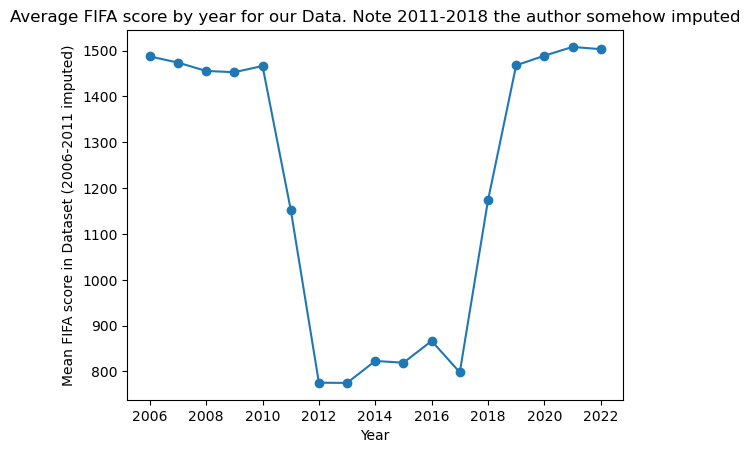

In [8]:
average_points_by_year = df.groupby('date')['home_team_total_fifa_points'].mean()
filtered_df = df.copy()
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df['year'] = filtered_df['date'].dt.year
average_points_by_year = filtered_df.groupby('year')['home_team_total_fifa_points'].mean()

plt.plot(average_points_by_year.index, average_points_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean FIFA score in Dataset (2006-2011 imputed)')
plt.title('Average FIFA score by year for our Data. Note 2011-2018 the author somehow imputed')
plt.show()

Interestingly, it would appear the average value for ELO is consistent for the date ranges imputed between 2006 and 2011, as they're mean closer to the values beginning in 2018 (which would be exact values from FIFA), and they dataset we're using has inaccurate ELO scores from 2011-2018. For future iterations we'll look to correct this imbalance and explore modeling using FIFA's score as one of our models for comparison and integration in the blended model. 

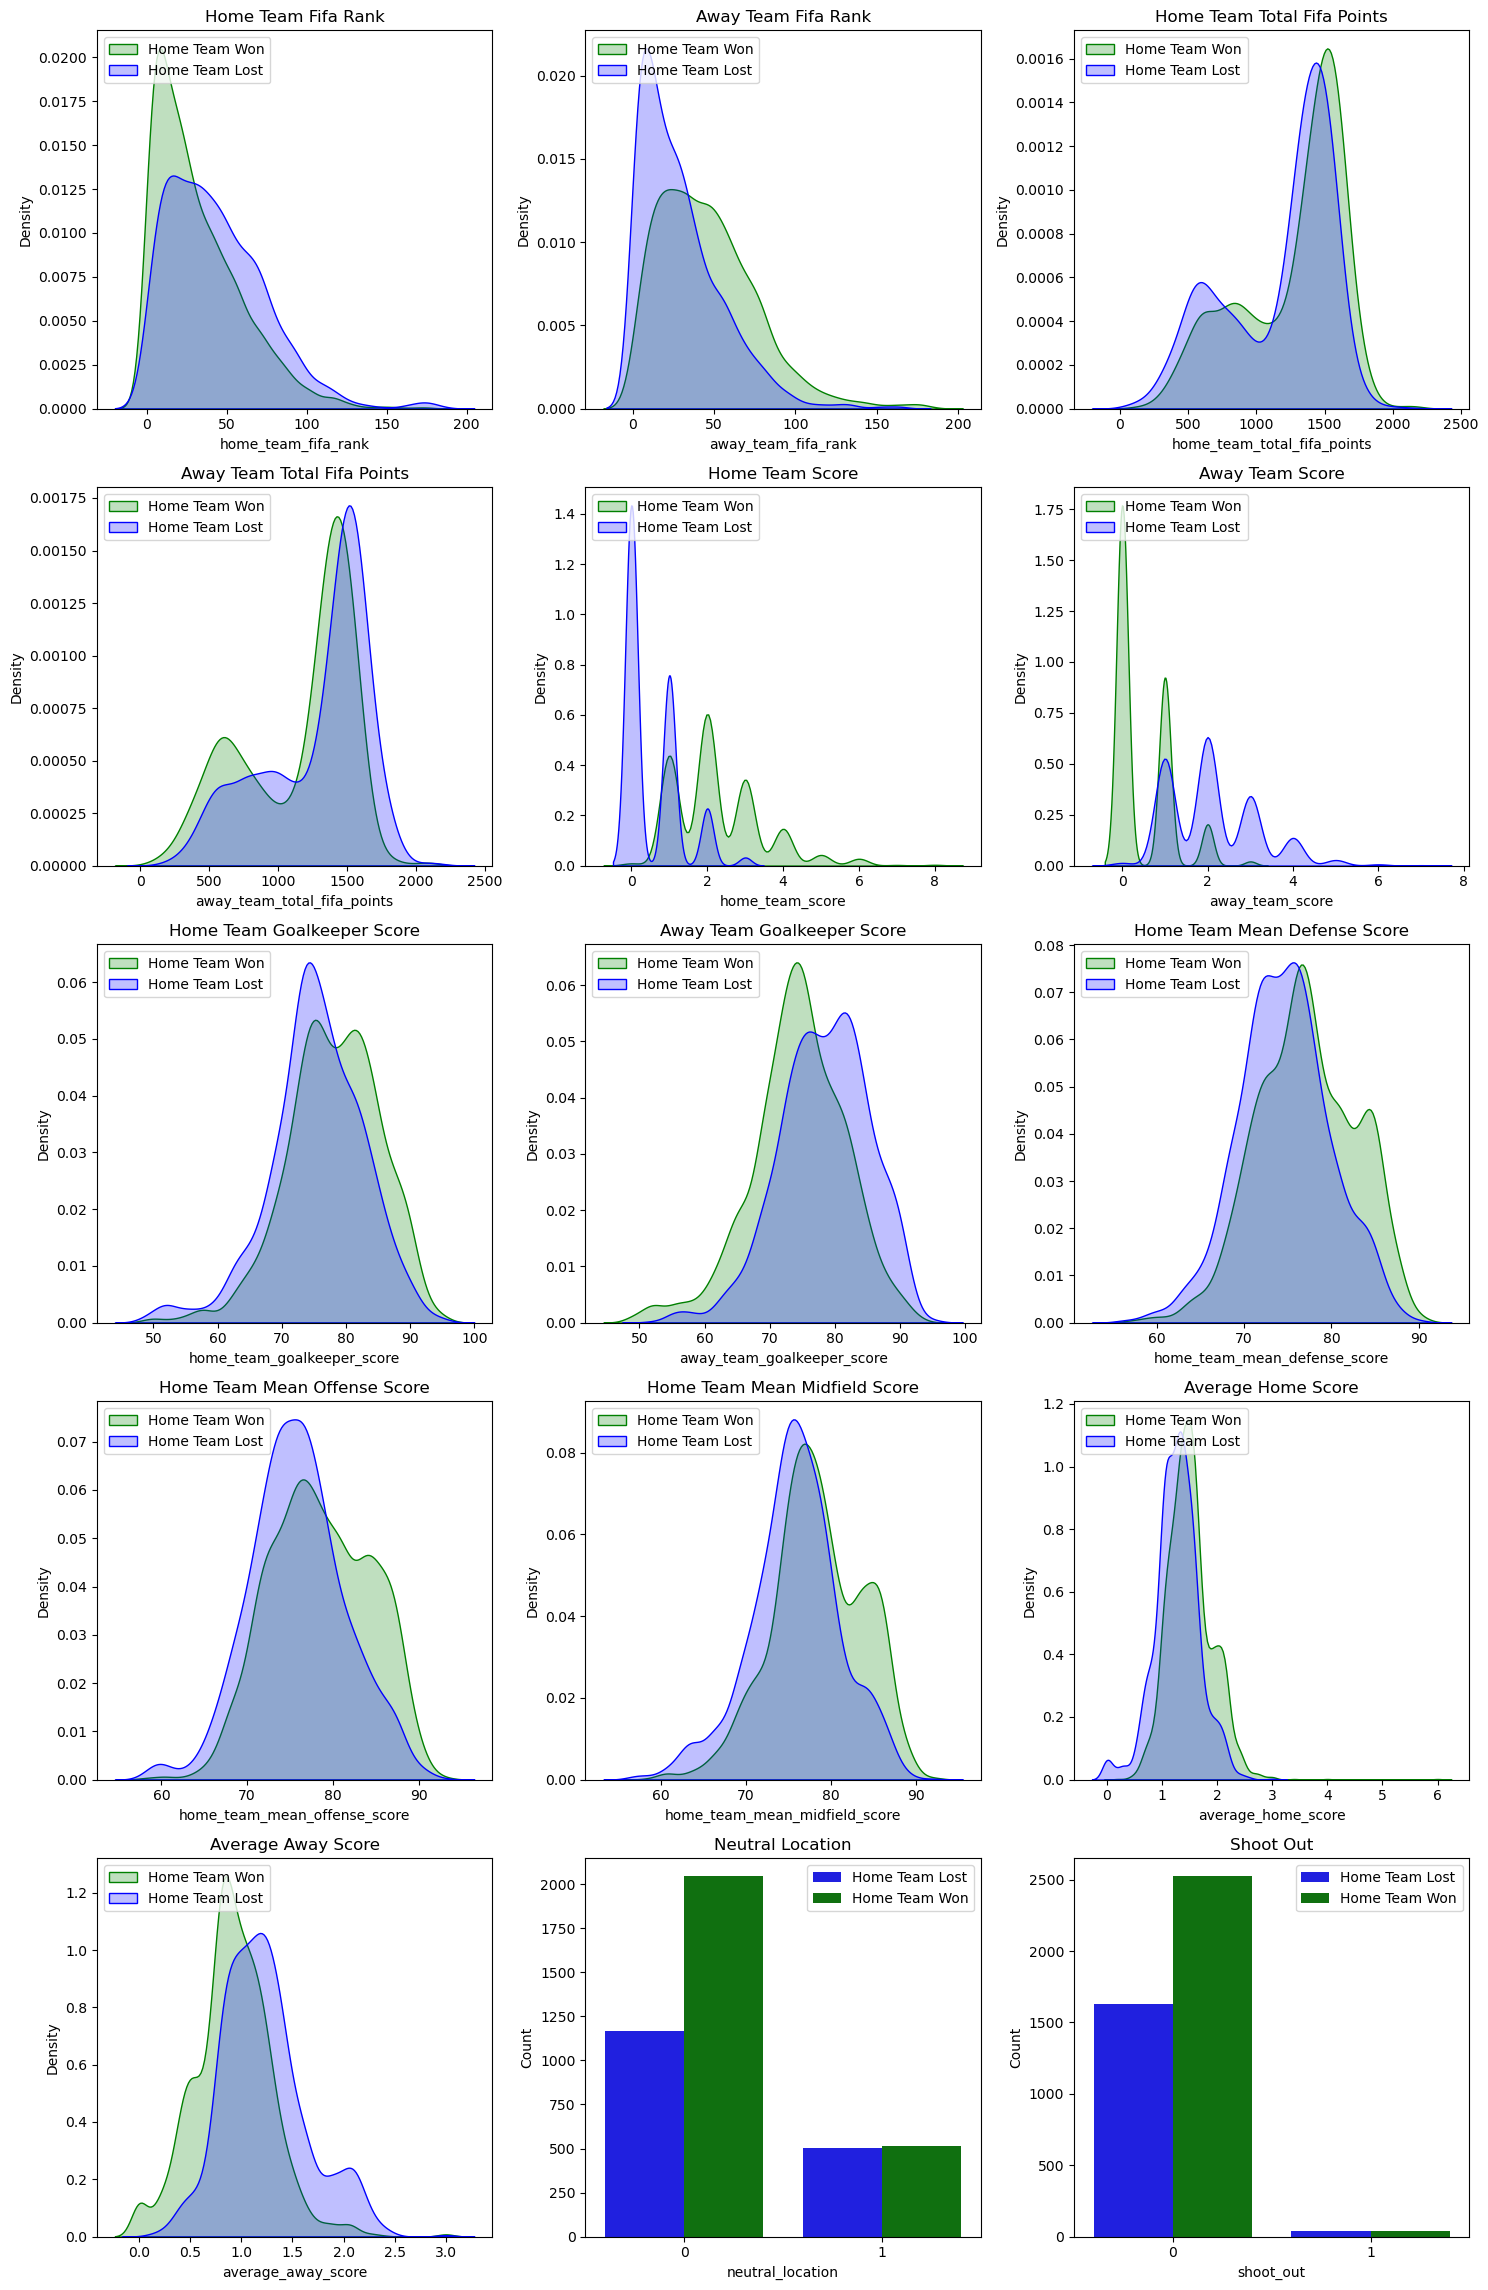

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for win/loss only (excluding draws)
df_no_draws = df[df['home_team_result'] != 0].copy()  # Filter out draws
df_no_draws['home_team_win'] = df_no_draws['home_team_result'].apply(lambda x: 1 if x == 1 else 0)

# Define quantitative and binary predictors
quant_predictors = [
    "home_team_fifa_rank", "away_team_fifa_rank", "home_team_total_fifa_points", 
    "away_team_total_fifa_points", "home_team_score", "away_team_score", 
    "home_team_goalkeeper_score", "away_team_goalkeeper_score", 
    "home_team_mean_defense_score", "home_team_mean_offense_score", 
    "home_team_mean_midfield_score", "average_home_score", "average_away_score"
]
binary_predictors = ["neutral_location", "shoot_out"]

predictors = quant_predictors + binary_predictors
labels = [
    "Home Team Fifa Rank", "Away Team Fifa Rank", "Home Team Total Fifa Points", "Away Team Total Fifa Points",
    "Home Team Score", "Away Team Score", "Home Team Goalkeeper Score", "Away Team Goalkeeper Score",
    "Home Team Mean Defense Score", "Home Team Mean Offense Score", "Home Team Mean Midfield Score",
    "Average Home Score", "Average Away Score", "Neutral Location", "Shoot Out"
]

# Define binary label mappings for readability
binary_label_mapping = {
    "shoot_out": {0: "0", 1: "1"},
    "neutral_location": {0: "0", 1: "1"}
}

# Set up the grid of subplots (5 rows x 3 columns to accommodate 15 plots)
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
axes = axes.ravel()

for i, (predictor, label) in enumerate(zip(predictors, labels)):
    won_games = df_no_draws[df_no_draws["home_team_win"] == 1]
    lost_games = df_no_draws[df_no_draws["home_team_win"] == 0]
    
    if predictor in quant_predictors:
        # Plot KDE for quantitative predictors
        sns.kdeplot(won_games[predictor], ax=axes[i], label='Home Team Won', color='green', fill=True)
        sns.kdeplot(lost_games[predictor], ax=axes[i], label='Home Team Lost', color='blue', fill=True)
        axes[i].legend(loc='upper left')
    else:
        # Map binary labels for readability and plot count plot for binary predictors
        df_no_draws[predictor] = df_no_draws[predictor].map(binary_label_mapping[predictor])
        sns.countplot(data=df_no_draws, x=predictor, hue="home_team_win", ax=axes[i], palette=["blue", "green"])
        axes[i].legend(["Home Team Lost", "Home Team Won"], loc='upper right')
        axes[i].set_ylabel('Count')
    
    axes[i].set_title(label)

# Remove any extra subplots if there are empty ones
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on our cleaned dataset, we can see there are some predictors that may have importance after we fit our models. The average score for the team seems to be impactful, which is expected (the team that scores more wins), but looking at the distributions the suprising initial observations are the impact that neutral location and goalkeeper score seem to have for the home team's victory, with teams heavily favored if it's a non neutral location and they're the home team. 

Due to the ordinal nature of the team's ranking, we'll likely omit it as a data source for modeling, and may explore non-linear transforms for future models, though there seems to be a fairly impactful relationship with lower ranked teams winning disproportionately over other highly ranked teams. 

# 3. Modeling Approach (Primary Approach)

## 3.1. Understanding the FIFA World Cup Format

Before fitting our baseline models, it is important to first understand the basics/format of the 2022 World Cup so as to better explain our rationale for choosing the following two models (OvR Logistic Regression and Simple Logistic Regression). The 2022 World Cup is divided into 5 rounds. The first round starts with 32 international teams (teams are divided up into 8 groups (4 teams per group) randomly). Each team plays a total of 3 games in the first round (1 against each team in their respective group). It is important to note that a draw is allowed in the first round. Consequently, a team can win, draw, or lose (i.e. a win is 3 points, a draw is 1 point, and a loss is 0 points). The top 2 teams with the most amount of points advance to the knockout stages (rounds 2-5 of the world cup). Unlike the first round, the knockout stages resemble the format/layout of an NBA bracket tournament (that is, if a team wins, they advance to the next round while the losing team is out of the tournament).

## 3.2 Modeling Strategy

As a result of these "two stages" of the 2022 World Cup (The Group Stage and the Knockout Stage), we decided to use two different models to represent/predict the outcomes of each respective phase. Specifically, we decided to use an OvR Logistic Regression model for the first phase since the response variable has to be non-binary (i.e. has more than 2 potential categorical outcomes: win (1), draw (0), or loss (-1)). In essence, this model will predict the probability of team 1 winning, the probability of team 1 drawing, and the probability of team 1 losing against team 2 given some soccer stats (predictors) of each team.

For the reamining 4 rounds (i.e. rounds 2-5 (the Knockout Stage)), we decided to use a Simple Logistic Regression model since the response variable (in this case) must be binary (i.e. has 2 potential categorical outcomes: win (1) or loss (-1)). It is important to note that when training this model, we removed the rows/matches that resulted in the home team obtaining a draw (0) so as to fit this model to data that contains only a binary response variable (only wins or losses). Training this model on the udpated data without draws, in our opinion, would better reflect the Knockout Stage. 

To sum up, we are using 2 models to predict pairwise probabilities between two teams. We are using the OvR Logistic Regression Model to predict the pairwise probabilities (probability of team 1 winning, probability of team 1 drawing, and probability of team 1 losing against team 2) for each team for the first round of the World Cup; and we are using the Simple Logistic Regression Model to predict the pairwise probabilities (probabilitiy of team 1 winning and probability of team 1 losing against team 2) for the remaining Knockout rounds (rounds 2 - 5). Finally, we can use these predicted pairwise probabilities to simulate the World Cup outcome (probability of each team winning the entire World Cup Championship) using a Monte Carlo Simulation. 

## 3.3 Train/Test Splits and Standardization

- **Train/Test Split**: We split the dataset into 80% training and 20% testing, stratified on `home_team_result`.
- **Standardization**: Standardized quantitative predictors (e.g., FIFA rank, team scores) using `StandardScaler`.
- **Feature Selection**:  
   - Excluded unnecessary columns (e.g., team names, scores, tournament).  
   - Stored team names separately for later interpretation.
- **Final Data**:  
   - `X_train`, `X_test`: Predictor features.  
   - `y_train`, `y_test`: Target variable (`home_team_result`).

In [10]:
## Splitting Data into Training and Testing
worldCup_train, worldCup_test = train_test_split(
    worldCup,
    test_size=0.2,
    random_state=109,
    shuffle=True,
    stratify=worldCup["home_team_result"],
)

## Standardizing Quantitative Predictors
quantPredictors = ['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points',
                   'away_team_total_fifa_points', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
                   'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score',
                   'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score',
                   'average_home_score', 'average_away_score']
standardize = StandardScaler()
worldCup_train[quantPredictors] = standardize.fit_transform(worldCup_train[quantPredictors])
worldCup_test[quantPredictors] = standardize.transform(worldCup_test[quantPredictors])

## Storing Team Names (For Later when Interpreting Results)
teams = worldCup_test[["home_team", "away_team"]].reset_index(drop=True)

## Storing Training/Testing Data into Variables and Excluding Unecessary Predictors
X_train, y_train = worldCup_train.drop(columns=["home_team_result", "home_team", "away_team", "tournament", "home_team_score", "away_team_score", "shoot_out"]), worldCup_train["home_team_result"]
X_test, y_test = worldCup_test.drop(columns=["home_team_result", "home_team", "away_team", "tournament", "home_team_score", "away_team_score", "shoot_out"]), worldCup_test["home_team_result"]

## 3.4 Fitting Model 1: OvR Logistic Regression for Round 1 (Group Stage)

We train a multi-class **Logistic Regression** model to predict match outcomes (win, draw, or loss) for the group stage.  
- The model uses Lasso regularization to prevent overfitting and handles class imbalance by balancing weights.  
- It applies a **One-vs-Rest (OvR)** strategy, as we have explained previously, where separate classifiers are built for each outcome.  
- The model is trained on standardized predictors from the training dataset.

In [11]:
Cs = np.logspace(-2,2,20)

## Creating Logistic Regression Model 
logit_lasso = LogisticRegressionCV(
    Cs=Cs,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=109,
    cv=5,
    class_weight='balanced',
    multi_class = 'ovr'
)

## Converting to Multi-Class Classifier via OneVsRestClassifier()
ovrModel = OneVsRestClassifier(logit_lasso)

## Fitting Model to Data
ovrModel.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                                                   class_weight='balanced',
                                                   cv=5, max_iter=1000,
                                                   multi_class='ovr',
                                                   penalty='l1',
                                                   random_state=109,
                                                   solver='liblinear'))

## 3.5 Fitting Model 2: Simple Logistic Regression for Rounds 2-5 (Knockout Stage)

To model the knockout stage, we exclude matches that ended in a draw and split the remaining data into training and testing sets. We standardize the predictors to ensure consistency and prepare the data for binary classification (win/loss).

In [12]:
## Excluding Rows with Matches Resulting in Draws
worldCupNoDraws = worldCup[worldCup['home_team_result'] != 0]

## Splitting Updated Data into Training and Testing
worldCupNoDraws_train, worldCupNoDraws_test = train_test_split(
    worldCupNoDraws,
    test_size=0.2,
    random_state=109,
    shuffle=True,
    stratify=worldCupNoDraws["home_team_result"],
)

## Standardizing Quantitative Predictors
quantPredictors = ['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points',
                   'away_team_total_fifa_points', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
                   'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score',
                   'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score',
                   'average_home_score', 'average_away_score']
standardize = StandardScaler()
worldCupNoDraws_train[quantPredictors] = standardize.fit_transform(worldCupNoDraws_train[quantPredictors])
worldCupNoDraws_test[quantPredictors] = standardize.transform(worldCupNoDraws_test[quantPredictors])

## Storing Team Names (For Later when Interpreting Results)
teamsNew = worldCupNoDraws_test[["home_team", "away_team"]].reset_index(drop=True)

## Storing Training/Testing Data into Variables and Excluding Unnecessary Predictors
X_trainNoDraws, y_trainNoDraws = worldCupNoDraws_train.drop(columns=["home_team_result", "home_team", "away_team", "tournament", "home_team_score", "away_team_score", "shoot_out"]), worldCupNoDraws_train["home_team_result"]
X_testNoDraws, y_testNoDraws = worldCupNoDraws_test.drop(columns=["home_team_result", "home_team", "away_team", "tournament", "home_team_score", "away_team_score", "shoot_out"]), worldCupNoDraws_test["home_team_result"]

We train a logistic regression model designed for binary classification to predict match outcomes (win/loss) in the knockout stage. Lasso Regularization is applied to prevent overfitting, and cross-validation ensures robust model performance.

In [13]:
## Creating Logistic Regression Model
Cs = np.logspace(-2, 2, 20)
logit_lassoNew = LogisticRegressionCV(
    Cs=Cs,
    penalty='l1', 
    solver='liblinear',
    max_iter=1000,
    random_state=109,
    cv=5,
    class_weight='balanced'
)

logit_lassoNew.fit(X_trainNoDraws, y_trainNoDraws)

LogisticRegressionCV(Cs=array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                     class_weight='balanced', cv=5, max_iter=1000, penalty='l1',
                     random_state=109, solver='liblinear')

# 4. Monte Carlo Simulation

## 4.1 Creating Dataset for 2022 World Cup Teams

We are creating a dataset containing the most up-to-date stats for all 2022 FIFA World Cup teams to be used in predictions.

1. **Filter Teams**: Extract data for the 32 teams participating in the 2022 World Cup.
2. **Aggregate Recent Stats**:  
   - Use the most recent match data for each team as their current stats.  
3. **Handle Missing Data**:  
   - Manually add statistics for **Qatar**, as it was not present in the dataset.  
   - Based on research, Qatar's stats were approximated using Venezuela's most recent data due to similar performance levels.
4. **Standardize Predictors**:  
   - Apply `StandardScaler` to ensure consistent scaling across all quantitative predictors.

In [14]:
## Getting Most Recent World Cup Team Stats
worldCupTeams = ["Qatar", "Ecuador", "Senegal", "Netherlands", "England", 
                 "IR Iran", "USA", "Wales", "Argentina", "Saudi Arabia", "Mexico",
                 "Poland", "France", "Australia", "Denmark", "Tunisia",
                 "Spain", "Costa Rica", "Germany", "Japan",
                 "Belgium", "Canada", "Morocco", "Croatia", "Brazil",
                 "Serbia", "Switzerland", "Cameroon", "Portugal", "Ghana",
                 "Uruguay", "Korea Republic"]

## Creating New Dataset with Most Recent World Cup Team Stats
worldCupNew = worldCup[worldCup['home_team'].isin(worldCupTeams)]
worldCupRecentStats = worldCupNew.groupby('home_team').last().reset_index()
worldCupRecentStats.head()

## Adding Qatar Stats (Since Qatar Stats were not Included in Original Dataset)
## Note: After much research, we realized that Qatar and Venezuela are roughly equal
## in terms of strength and performance, therefore we used Venezuela's most recent stats
## as Qatar's stats
qatarRow = {
    "home_team": "Qatar",
    "away_team": "Slovenia",
    "home_team_fifa_rank": 52,
    "away_team_fifa_rank": 64,
    "home_team_total_fifa_points": 1437,
    "away_team_total_fifa_points": 1375,
    "home_team_score": 0,
    "away_team_score": 0,
    "tournament": "Friendly",
    "neutral_location": 0,
    "shoot_out": 0,
    "home_team_result": 0,
    "home_team_goalkeeper_score": 73,
    "away_team_goalkeeper_score": 91,
    "home_team_mean_defense_score": 72.8,
    "home_team_mean_offense_score": 76.3,
    "home_team_mean_midfield_score": 77.8,
    "away_team_mean_defense_score": 73,
    "away_team_mean_offense_score": 77,
    "away_team_mean_midfield_score": 76.2,
    "average_home_score": 0.9,
    "average_away_score": 1.155,
}

## Concatenating New Row to Recent World Cup Team Stats Data
worldCupRecentStats.loc[len(worldCupRecentStats)] = qatarRow

## Standardizing Quantitative Predictors
standardize = StandardScaler()
worldCupRecentStats[quantPredictors] = standardize.fit_transform(worldCupRecentStats[quantPredictors])

## 4.2 Simulating the Group Stage

Helper functions that we are creating for simulation:

1. **Prepare Match Input**:  
   - The `prepare_match_input` function converts stats from `worldCupRecentStats` into a structured format for model predictions.  
   - Ensures all necessary features (e.g., ranks, scores, and performance metrics) are properly aligned for the two teams being compared.

2. **Simulate Group Stage**:  
   - Teams in each group compete in a round-robin format.  
   - Match outcomes are simulated using probabilities predicted by the OvR Logistic Regression model:
     - **Win**: +3 points.  
     - **Draw**: +1 point for each team.  
     - **Loss**: 0 points.  
   - Results are aggregated for each team in all groups to calculate total points.

The output is:
- **Group Stage Results**: A dictionary of teams and their total points within each group, reflecting performance across all matches.


In [15]:
## Function that Takes in "WorldCupRecentStats" and Converts it to 
## Input Format that Both Models are Expecting (i.e. Pairs up World Cup Teams
## in a Way That is Consistent with What the Model is Expecting)
def prepare_match_input(teamOne, teamTwo, worldCupRecentStats):
    teamOne = worldCupRecentStats[worldCupRecentStats['home_team'] == teamOne]
    teamTwo = worldCupRecentStats[worldCupRecentStats['home_team'] == teamTwo]
    
    matchInput = pd.DataFrame({
        "home_team_fifa_rank": teamOne["home_team_fifa_rank"].values,
        "away_team_fifa_rank": teamTwo["home_team_fifa_rank"].values,
        "home_team_total_fifa_points": teamOne["home_team_total_fifa_points"].values,
        "away_team_total_fifa_points": teamTwo["home_team_total_fifa_points"].values,
        "neutral_location": teamOne["neutral_location"].values,
        "home_team_goalkeeper_score": teamOne["home_team_goalkeeper_score"].values,
        "away_team_goalkeeper_score": teamTwo["home_team_goalkeeper_score"].values,
        "home_team_mean_defense_score": teamOne["home_team_mean_defense_score"].values,
        "home_team_mean_offense_score": teamOne["home_team_mean_offense_score"].values,
        "home_team_mean_midfield_score": teamOne["home_team_mean_midfield_score"].values,
        "away_team_mean_defense_score": teamTwo["home_team_mean_defense_score"].values,
        "away_team_mean_offense_score": teamTwo["home_team_mean_offense_score"].values,
        "away_team_mean_midfield_score": teamTwo["away_team_mean_midfield_score"].values,
        "average_home_score": teamOne["average_home_score"].values,
        "average_away_score": teamTwo["average_away_score"].values,
    })
    return matchInput



## Function that Simulates Group Stage of World Cup (Returns Total Points
## for Each Team)
def simulateGroupStage(groups, worldCupRecentStats):

    ## Initializing Group Tracker
    overallGroupResults = {}
    for group, teams in groups.items():
        groupResults = {}
        for i in teams:
            groupResults[i] = 0
        overallGroupResults[group] = groupResults

    ## Iterating Through Each Group and Simulating Round-Robin
    ## Matches Outcome Within Each Group (+3 for a win, +1 for a draw
    ## and 0 for a loss)
    for group, teams in groups.items():
        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                teamOne = teams[i]
                teamTwo = teams[j]

                matchInput = prepare_match_input(teamOne, teamTwo, worldCupRecentStats)
                predProbs = ovrModel.predict_proba(matchInput)
                outcome = np.random.choice([-1, 0, 1], p=predProbs[0])

                if outcome == -1:
                    overallGroupResults[group][teams[j]] += 3
                elif outcome == 0:
                    overallGroupResults[group][teams[i]] += 1
                    overallGroupResults[group][teams[j]] += 1
                elif outcome == 1:
                    overallGroupResults[group][teams[i]] += 3
    
    return  overallGroupResults

## 4.3 Simulating the Knockout Stage

This is a helper function to simulate the Knockout Stages of the World Cup:

1. **Prepare Teams for Knockout Stage**:  
   - Sort group stage results to rank teams by points.  
   - Retain only the top two teams from each group to advance to the knockout stage.

2. **Simulate Matches for Each Round**:  
   - **Round of 16**: Create match pairings based on group rankings and simulate outcomes using the **Simple Logistic Regression** model.  
   - **Quarterfinals**: Winners from the Round of 16 are paired, and matches are simulated.  
   - **Semifinals**: Winners from the Quarterfinals compete for a spot in the finals.  
   - **Finals**: Two remaining teams face off to determine the World Cup winner.

3. **Match Simulation**:  
   - For each match, use the model's predicted probabilities and a random selection to determine the winner.  

The output is:
- The final winner of the World Cup after simulating all knockout stage matches.

In [16]:
## Function that Simulates KnockoutStage of World Cup (returns World Cup Winner)
def simulateKnockoutStage(overallGroupResults, worldCupRecentStats):

    ## Sorting Dictionaries Within each Group from Largest to Smallest (Left to Right)
    for group, teams in overallGroupResults.items():
        teams = {i: j for i, j in sorted(teams.items(), key=lambda value: value[1], reverse=True)}
        overallGroupResults[group] = teams

    ## Removing Two Teams with Lowest Points from Group Stage
    ## (Since Top 2 Teams from Each Group from Group Stage
    ## Advance to Knockout Stage)
    for group, teams in overallGroupResults.items():
        teams.popitem()
        teams.popitem()
        overallGroupResults[group] = teams

    ## Creating Round of 16 Match Pairings
    sixteenPairings = []
    sixteenPairings.append([list(overallGroupResults['A'].keys())[0], list(overallGroupResults['B'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['C'].keys())[0], list(overallGroupResults['D'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['E'].keys())[0], list(overallGroupResults['F'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['G'].keys())[0], list(overallGroupResults['H'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['B'].keys())[0], list(overallGroupResults['A'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['D'].keys())[0], list(overallGroupResults['C'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['F'].keys())[0], list(overallGroupResults['E'].keys())[1]])
    sixteenPairings.append([list(overallGroupResults['H'].keys())[0], list(overallGroupResults['G'].keys())[1]])

    ## Simulating Round of 16
    roundSixteenWinners = []
    for i in sixteenPairings:
        teamOne = i[0]
        teamTwo = i[1]

        matchInput = prepare_match_input(teamOne, teamTwo, worldCupRecentStats)
        predProbs = logit_lassoNew.predict_proba(matchInput)
        outcome = np.random.choice([-1, 1], p=predProbs[0])

        if outcome == 1:
            roundSixteenWinners.append(teamOne)
        elif outcome == -1:
            roundSixteenWinners.append(teamTwo)
    
    ## Creating Round of 8 Match Pairings
    eightPairings = []
    eightPairings.append([roundSixteenWinners[0],roundSixteenWinners[2]])
    eightPairings.append([roundSixteenWinners[1],roundSixteenWinners[3]])
    eightPairings.append([roundSixteenWinners[4],roundSixteenWinners[6]])
    eightPairings.append([roundSixteenWinners[5],roundSixteenWinners[7]])
    
    ## Simulating Round of 8
    roundEightWinners = []
    for i in eightPairings:
        teamOne = i[0]
        teamTwo = i[1]

        matchInput = prepare_match_input(teamOne, teamTwo, worldCupRecentStats)
        predProbs = logit_lassoNew.predict_proba(matchInput)
        outcome = np.random.choice([-1, 1], p=predProbs[0])

        if outcome == 1:
            roundEightWinners.append(teamOne)
        elif outcome == -1:
            roundEightWinners.append(teamTwo)

    ## Semifinals Match Pairings
    semiPairings = []
    semiPairings.append([roundSixteenWinners[0],roundSixteenWinners[1]])
    semiPairings.append([roundSixteenWinners[2],roundSixteenWinners[3]])

    ## Simulating Semifinals
    semiWinners = []
    for i in semiPairings:
        teamOne = i[0]
        teamTwo = i[1]

        matchInput = prepare_match_input(teamOne, teamTwo, worldCupRecentStats)
        predProbs = logit_lassoNew.predict_proba(matchInput)
        outcome = np.random.choice([-1, 1], p=predProbs[0])

        if outcome == 1:
            semiWinners.append(teamOne)
        elif outcome == -1:
            semiWinners.append(teamTwo)
    
    ## Finals Match Pairing
    finalPairing = [semiWinners[0], semiWinners[1]]

    ## Simulating Final Match
    winner = ""
    teamOne = finalPairing[0]
    teamTwo = finalPairing[1]

    matchInput = prepare_match_input(teamOne, teamTwo, worldCupRecentStats)
    predProbs = logit_lassoNew.predict_proba(matchInput)
    outcome = np.random.choice([-1, 1], p=predProbs[0])

    if outcome == 1:
        winner = teamOne
    elif outcome == -1:
        winner = teamTwo

    return winner

## 4.4 Full Tournament Monte Carlo Simulation

This is a full Monte Carlo simulation of the World Cup using the helper functions that we just created. The goal is to predict the probabilities of each team winning the 2022 FIFA World Cup.

Steps:
1. **Initialize Groups**:  
   - Define the official 2022 World Cup group stage structure, with 8 groups (A–H), each containing 4 teams.

2. **Monte Carlo Simulation**:  
   - Run 1,000 simulations of the World Cup, including:  
     - **Group Stage**: Simulate all matches within each group to compute team rankings.  
     - **Knockout Stage**: Simulate matches for rounds of 16, quarterfinals, semifinals, and finals to determine the tournament winner.  
   - Track the winner of each simulation.

3. **Calculate Probabilities**:  
   - Count the number of simulations each team wins and compute their probability of winning as a percentage.

4. **Sort Results**:  
   - Create a sorted dictionary showing each team's probability of winning, ranked from highest to lowest.

The output is:
- A ranked list of teams with their predicted probabilities of winning the World Cup.


In [17]:
## Declaring/Initializing 2022 World Cup Groups
groups = {
    "A": ["Qatar", "Ecuador", "Senegal", "Netherlands"],
    "B": ["England", "IR Iran", "USA", "Wales"],
    "C": ["Argentina", "Saudi Arabia", "Mexico", "Poland"],
    "D": ["France", "Australia", "Denmark", "Tunisia"],
    "E": ["Spain", "Costa Rica", "Germany", "Japan"],
    "F": ["Belgium", "Canada", "Morocco", "Croatia"],
    "G": ["Brazil", "Serbia", "Switzerland", "Cameroon"],
    "H": ["Portugal", "Ghana", "Uruguay", "Korea Republic"],
}

## Executing Monte Carlo Simulation
numSims = 1000
winnerTracker = []
for i in range(numSims):
    overallGroupResults = simulateGroupStage(groups, worldCupRecentStats)
    winner = simulateKnockoutStage(overallGroupResults, worldCupRecentStats)
    winnerTracker.append(winner)

## Counting Number of Wins for Each Team (after 1000 simulations)
winCount = Counter(winnerTracker)
probOfWinning = {}
for team, count in winCount.items():
    probOfWinning[team] = (count/numSims)*100

## Sorting Probability of Winning Dictionary
sortedProbOfWinning = {i: j for i, j in sorted(probOfWinning.items(), key=lambda value: value[1], reverse=True)}

# 5. Evaluating and Analyzing Results

The results section will be divided into two parts: 1. Analyzing OvR Logistic Regression & Simple Logistic Regression Model Peformance, Output, and Feature Importance, 2. Anlayzing Our Predicted 2022 World Cup Results (from the predicted pair-wise probabilities and the Monte Carlo simulation). Additionally, it is important to note that the model performance analysis was done with the original testing data (not the World Cup data since we're assuming that we don't have knowlege of the World Cup Outcomes).

## 5.1 Model 1 Accuracy and ROC AUC Scores

#### OvR Logistic Regression Model Evaluation (On Unseen/Testing Data)

In [18]:
## Computing and Printing OvR Logistic Regression Model Accuracy
yPredOvR = ovrModel.predict(X_test)
accuracyOvR = accuracy_score(y_test, yPredOvR)
print(f"OvR Logistic Regression Model Accuracy: {accuracyOvR}")

## Computing and Printing OvR Logistic Regression Model ROC AUC Score
yPredProbOvR = ovrModel.predict_proba(X_test)
rocAucOvR = roc_auc_score(y_test, yPredProbOvR, multi_class = 'ovr')
print(f"OvR Logistic Regression Model ROC AUC Score: {rocAucOvR}")

OvR Logistic Regression Model Accuracy: 0.569838056680162
OvR Logistic Regression Model ROC AUC Score: 0.7166711475792596


1. **Accuracy**:  
   While an accuracy of ~57% may seem low, it is important to consider that the model is tackling a challenging multi-class problem. This performance is reasonable given the multi-class nature of the problem and the inherent unpredictability of sports outcomes. Sports outcomes are influenced by many random factors, making perfect predictions unlikely. Additionally, the team's performance in the group stage exhibited a wide distribution of scores (ranging from 0 to 12), so achieving 57% accuracy still seems pretty good (better than random chance, when the games can often come down to nearly 50-50 probabilities).

2. **ROC AUC**:  
   A score above 0.7 suggests the model performs better than random guessing and captures meaningful patterns in the data.

Overall, the model provides a solid baseline for predicting group-stage outcomes, but further refinements could improve its accuracy and discriminatory power.

## 5.2 Model 2 Accuracy and F1 Score

In [19]:
## Computing and Printing Simple Logistic Regression Model Accuracy
yPredLogit = logit_lassoNew.predict(X_testNoDraws)
accuracyLogit = accuracy_score(y_testNoDraws, yPredLogit)
print(f"Simple Logistic Regression Model Accuracy: {accuracyLogit}")

## Computing and Printing Simple Logistic Regression Model F1-Score
f1ScoreLogit = f1_score(y_testNoDraws, yPredLogit)
print(f"Simple Logistic Regression Model F1-Score: {f1ScoreLogit}")

Simple Logistic Regression Model Accuracy: 0.7388963660834454
Simple Logistic Regression Model F1-Score: 0.7733644859813084


1. **Accuracy**:  
   An accuracy of ~74% reflects the model's ability to capture key patterns in the data while handling the relatively smaller dataset for knockout matches.

2. **F1-Score**:  
   The high F1-Score indicates robust performance, particularly in scenarios where class imbalances or errors (e.g., predicting losses instead of wins) could impact model evaluation.

The Simple Logistic Regression model performs well, providing reliable predictions for the binary win/loss outcomes in the knockout stage. Its balance between precision and recall makes it suitable for this specific task.

## 5.3 Displaying Predicted Probabilities for Model 1

In [20]:
## Storing Outcome Probabilties
yPredOvR = ovrModel.predict_proba(X_test)

## Converting Outcome Probabilites into DataFrame with Headers (for Display)
yPredOvR_df = pd.DataFrame(yPredOvR, columns=["Probability of Home Team Losing", "Probability of Home Team Drawing", "Probability of Home Team Winning"])
OvR_results = pd.concat([teams, yPredOvR_df], axis=1)

## Displaying Outcome Probabiltiies for Each Match in Testing Set
print("First Few Rows of Predicted Probabilities (OvR Logistic Regression):")
OvR_results.head()

First Few Rows of Predicted Probabilities (OvR Logistic Regression):


,home_team,away_team,Probability of Home Team Losing,Probability of Home Team Drawing,Probability of Home Team Winning
0,Sweden,Slovakia,0.311,0.300,0.389
1,Germany,Northern Ireland,0.046,0.296,0.658
2,Chile,Mexico,0.312,0.324,0.364
3,Benin,Cameroon,0.494,0.337,0.169
4,Argentina,Uruguay,0.282,0.300,0.418


## 5.4 Displaying Predicted Probabilities for Model 2

In [21]:
## Storing Outcome Probabilties
yPredLogit = logit_lassoNew.predict_proba(X_testNoDraws)

## Converting Outcome Probabilites into DataFrame with Headers (for Display)
yPredLogit_df = pd.DataFrame(yPredLogit, columns=["Probability of Home Team Losing", "Probability of Home Team Winning"])
Logit_results = pd.concat([teamsNew, yPredLogit_df], axis=1)

## Displaying Outcome Probabiltiies for Each Match in Testing Set
print("First Few Rows of Predicted Probabilities (Simple Logistic Regression Model):")
Logit_results.head()

First Few Rows of Predicted Probabilities (Simple Logistic Regression Model):


,home_team,away_team,Probability of Home Team Losing,Probability of Home Team Winning
0,Morocco,Ghana,0.401,0.599
1,Guinea,Senegal,0.630,0.370
2,Austria,Romania,0.451,0.549
3,Germany,Russia,0.167,0.833
4,Colombia,Chile,0.745,0.255


## 5.5 Feature Importance and Coefficient Analysis for Model 1

We are analyzing the coefficients of the OvR Logistic Regression model to understand the importance and influence of each feature in predicting match outcomes (win, draw, loss).


In [22]:
estimator = ovrModel.estimators_

## Creating Empty Original and Absolute Value Coefficients Dictionaries for Losing, Drawing, and Winning
coefficientsLosing = {}
coefficientsLosingAbs = {}
coefficientsDrawing = {}
coefficientsDrawingAbs = {}
coefficientsWinning = {}
coefficientsWinningAbs = {}

## Inputting Original and Absolute Coefficient Values into Losing Coefficients Dictionary
index = 0
for i in estimator[0].coef_:
      for j in i:
         if j != 0:
            coefficientsLosingAbs[X_train.columns.tolist()[index]] = abs(float(j))
            coefficientsLosing[X_train.columns.tolist()[index]] = float(j)
         index += 1

## Inputting Original and Absolute Coefficient Values into Drawing Coefficients Dictionary
index = 0
for i in estimator[1].coef_:
      for j in i:
         if j != 0:
            coefficientsDrawingAbs[X_train.columns.tolist()[index]] = abs(float(j))
            coefficientsDrawing[X_train.columns.tolist()[index]] = float(j)
         index += 1

## Inputting Original and Absolute Coefficient Values into Winning Coefficients Dictionary
index = 0
for i in estimator[2].coef_:
      for j in i:
         if j != 0:
            coefficientsWinningAbs[X_train.columns.tolist()[index]] = abs(float(j))
            coefficientsWinning[X_train.columns.tolist()[index]] = float(j)
         index += 1

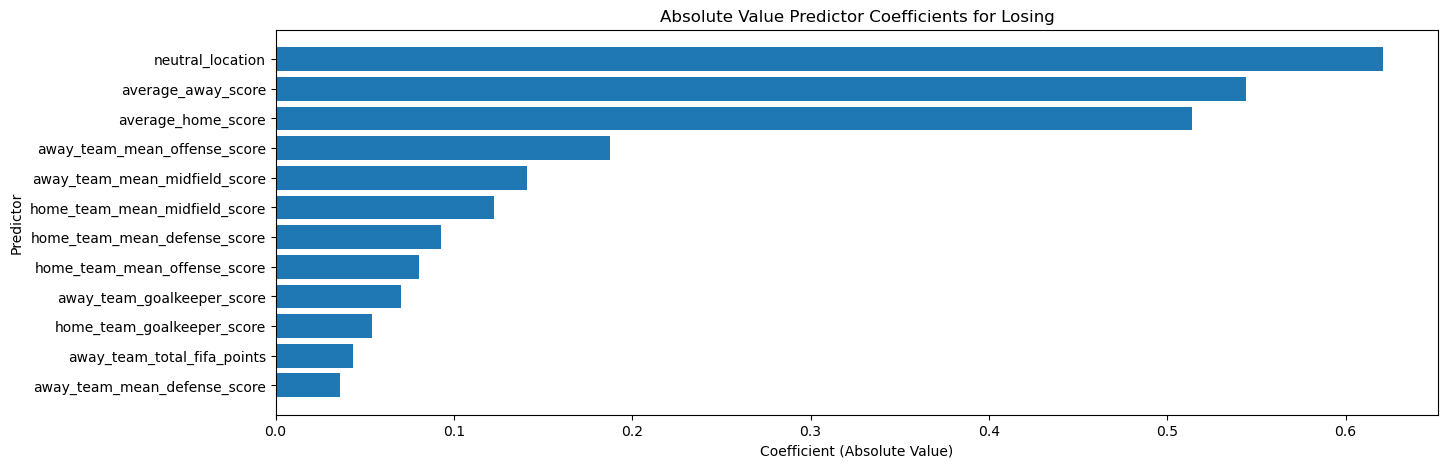

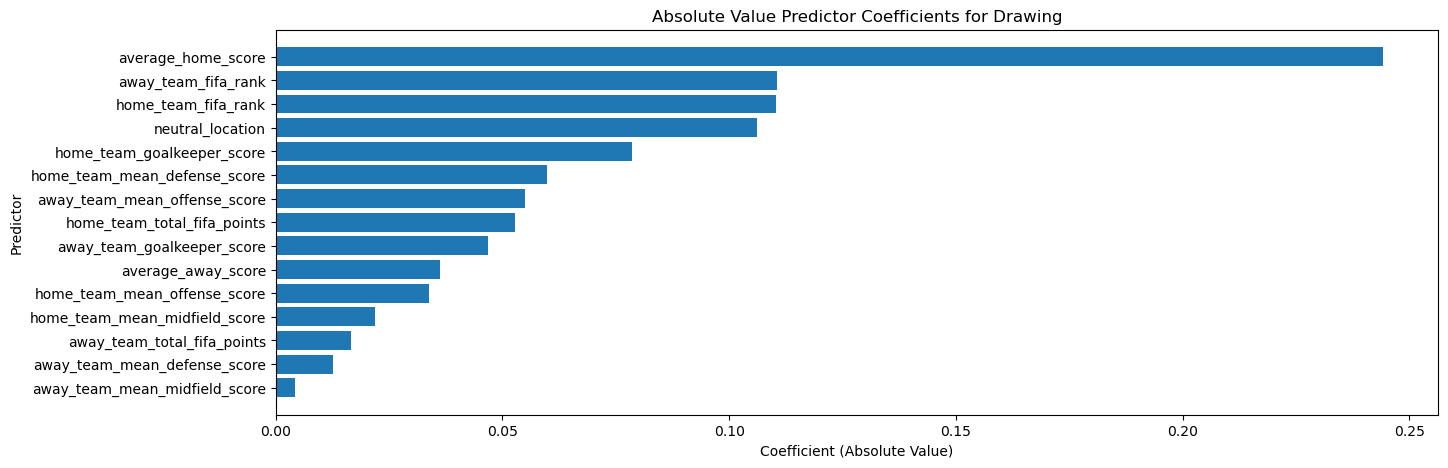

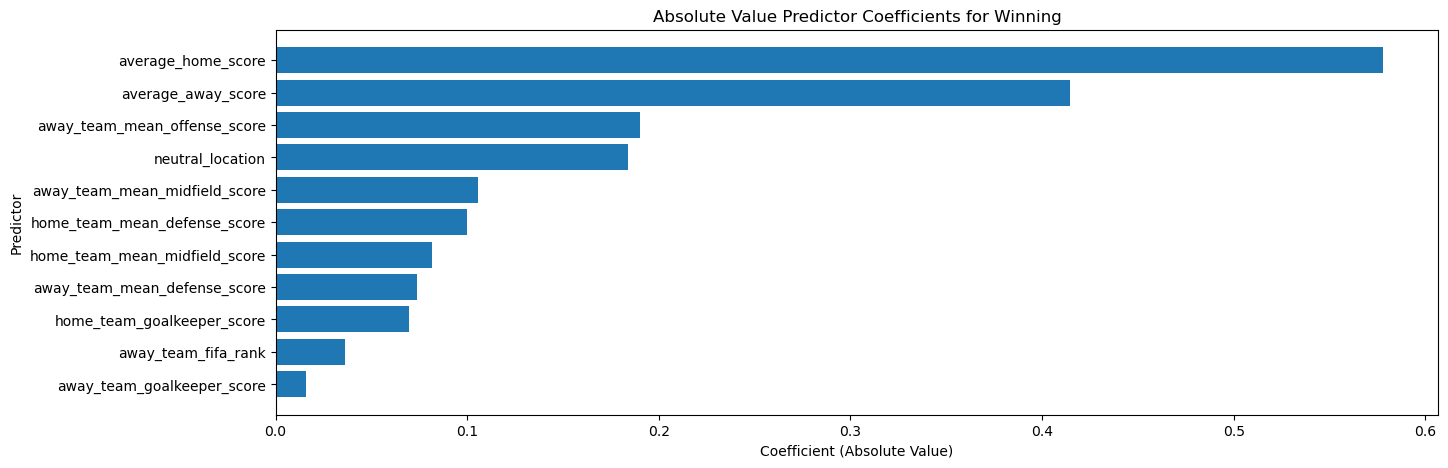

In [23]:
## Graphing Feature Importance for Losing (OvR Model)
coefficientsLosingDf = pd.DataFrame(list(coefficientsLosingAbs.items()), columns=["Predictor", "Importance"])
sortedCoefficientsLosingDf = coefficientsLosingDf.sort_values(by="Importance", ascending=True)
plt.figure(figsize=(15,5))
plt.barh(sortedCoefficientsLosingDf['Predictor'].tolist(), sortedCoefficientsLosingDf["Importance"].tolist())
plt.xlabel("Coefficient (Absolute Value)")
plt.ylabel("Predictor")
plt.title("Absolute Value Predictor Coefficients for Losing")
plt.show()

## Graphing Feature Importance for Drawing (OvR Model)
coefficientsDrawingDf = pd.DataFrame(list(coefficientsDrawingAbs.items()), columns=["Predictor", "Importance"])
sortedCoefficientsDrawingDf = coefficientsDrawingDf.sort_values(by="Importance", ascending=True)
plt.figure(figsize=(15,5))
plt.barh(sortedCoefficientsDrawingDf['Predictor'].tolist(), sortedCoefficientsDrawingDf["Importance"].tolist())
plt.xlabel("Coefficient (Absolute Value)")
plt.ylabel("Predictor")
plt.title("Absolute Value Predictor Coefficients for Drawing")
plt.show()

## Graphing Feature Importance for Winning (OvR Model)
coefficientsWinningDf = pd.DataFrame(list(coefficientsWinningAbs.items()), columns=["Predictor", "Importance"])
sortedCoefficientsWinningDf = coefficientsWinningDf.sort_values(by="Importance", ascending=True)
plt.figure(figsize=(15,5))
plt.barh(sortedCoefficientsWinningDf['Predictor'].tolist(), sortedCoefficientsWinningDf["Importance"].tolist())
plt.xlabel("Coefficient (Absolute Value)")
plt.ylabel("Predictor")
plt.title("Absolute Value Predictor Coefficients for Winning")
plt.show()

In [24]:
## Printing Raw Coefficient Values for Most Important Predictor for Simple Logistic Regression Model
print(f"Most Important Predictor Raw Coefficient Value for Loser (neutral_location): {coefficientsLosing["neutral_location"]}")
print(f"Most Important Predictor Raw Coefficient Value for Drawing (average_home_score): {coefficientsDrawing["average_home_score"]}")
print(f"Most Important Predictor Raw Coefficient Value for Winning (average_home_score): {coefficientsWinning["average_home_score"]}")

Most Important Predictor Raw Coefficient Value for Loser (neutral_location): 0.620908374098678
Most Important Predictor Raw Coefficient Value for Drawing (average_home_score): -0.2441379705653715
Most Important Predictor Raw Coefficient Value for Winning (average_home_score): 0.5778160373631906


#### **Losing Predictions**  
- **Top Predictors**:  
   - **Neutral Location**: The most impactful factor; matches played at neutral venues significantly increase the likelihood of losing, which is a surprising result. This is likely due to the lack of home-field advantage for home teams. For future analysis, we should not that this coeffiicent is an average, and some teams may perform significantly worse than others in a netural location, which is a difficult trend to capture team-by-team.
   - **Average Away/Home Score**: Higher scoring performance by the opponent increases the chance of a loss.  
   - **Away Team Strength**: Strong *offense* and *midfield* scores for the opposing team contribute to losses.  
In general, we can say that losing outcomes are primarily influenced by the opponent's offensive strength and match location.  

---

#### **Winning Predictions**  
- **Top Predictors**:  
   - **Average Home/Away Score**: The strongest predictors; a team's offensive scoring power (home or away) is critical for winning.  
   - **Away Team Offense**: Opponent's performance slightly influences winning predictions. The stronger the opponent's offense is, the less likely is the chance for the home team to win.
   - **Neutral Location**: Reduces home advantage, which slightly impacts winning outcomes.  
- **Key Insight**: Winning is driven by the opponents team's **offensive capabilities**, with match location having a secondary influence.  

---

#### **Drawing Predictions**  
- **Top Predictors**:  
   - **Average Home Score**: Surprisingly, this metric strongly contributes to predicting draws, likely due to balanced matches where teams have comparable scoring potential.
   - **FIFA Ranks**: Similar ranks between competing teams increase the likelihood of a draw.  
   - **Goalkeeper Scores**: Strong defensive performance, especially by goalkeepers, prevents decisive outcomes.  
- **Key Insight**: Draws are influenced by **team parity** (similar FIFA ranks) and **defensive performance**, especially from goalkeepers.  

---

### Overall Summary  
- **Winning/Losing**: Dominated by **offensive strength** and influenced by **neutral locations**.  
- **Draws**: Driven by **team balance** (FIFA ranks) and strong **defensive play**.  
- **Neutral Location**: Plays a significant role in reducing dominance and increasing uncertainty across outcomes.  


## 5.6 Feature Importance and Coefficient Analysis for Model 2

In [25]:
## Creating Empty Original and Absolute Value Coefficients Dictionaries for Simple Logistic Regression Model
coefficientsLogit = {}
coefficientsLogitAbs = {}

index = 0
for i in logit_lassoNew.coef_:
    for j in i:
        if j != 0:
            coefficientsLogitAbs[X_trainNoDraws.columns.tolist()[index]] = abs(float(j))
            coefficientsLogit[X_trainNoDraws.columns.tolist()[index]] = abs(float(j))
        index += 1

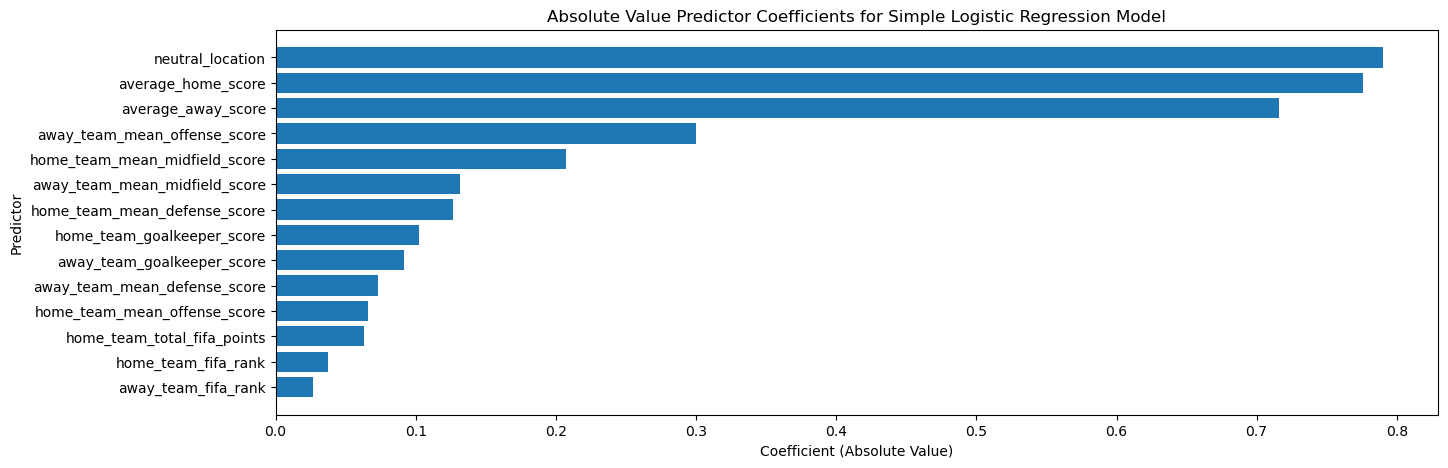

In [26]:
## Graphing Feature Importance for Simple Logistic Regression Model
coefficientsLogitDf = pd.DataFrame(list(coefficientsLogitAbs.items()), columns=["Predictor", "Importance"])
sortedCoefficientsLogitDf = coefficientsLogitDf.sort_values(by="Importance", ascending=True)
plt.figure(figsize=(15,5))
plt.barh(sortedCoefficientsLogitDf['Predictor'].tolist(), sortedCoefficientsLogitDf["Importance"].tolist())
plt.xlabel("Coefficient (Absolute Value)")
plt.ylabel("Predictor")
plt.title("Absolute Value Predictor Coefficients for Simple Logistic Regression Model")
plt.show()

In [27]:
## Printing Raw Coefficient Value for Most Important Predictor for Simple Logistic Regression Model
print(f"Most Important Predictor Raw Coefficient Value for Simple Logistic Regression Model (Neutral Location): {coefficientsLogit["neutral_location"]}")

Most Important Predictor Raw Coefficient Value for Simple Logistic Regression Model (Neutral Location): 0.7899991918129242


#### **Top Predictors**  
1. **Neutral Location**    
     - In knockout stages, neutral locations (no home advantage) create a level playing field.  
     - Teams relying on home advantage may underperform, increasing match unpredictability.  

2. **Average Home and Away Score**  
     - These metrics reflect a team’s offensive consistency.  
     - In knockout stages, scoring ability is critical since draws are resolved through extra time or penalties.  
     - Teams with higher average scores are more likely to secure wins.  

3. **Away Team Mean Offense and Midfield Scores**  
     - Opponent strength in offense and midfield increases difficulty for teams to win.  
     - Controlling the midfield often determines match dominance, especially in high-stakes knockout rounds.  


The Simple Logistic Regression model emphasizes offensive performance (average scores), neutral locations, and opponent strength as the most critical factors in determining outcomes in the knockout stages. This aligns well with the nature of single-elimination matches, where scoring efficiency and defensive solidity are paramount.


## 5.7 Predicted World Cup Results from Monte Carlo Simulation in 4.3

In [28]:
## Converting Our Probability Predictions to a DataFrame (for Display Purposes)
probOfWinningDf = pd.DataFrame(list(sortedProbOfWinning.items()), columns=['Team', 'Probability of Winning World Cup'])

## Printing Our Results
print("(Our Predictions) Each Team's Predicted Probability of Winning the 2022 World Cup (Top 5 Teams):")
probOfWinningDf.head()

(Our Predictions) Each Team's Predicted Probability of Winning the 2022 World Cup (Top 5 Teams):


,Team,Probability of Winning World Cup
0,Spain,26.1
1,Argentina,11.0
2,Germany,10.7
3,Netherlands,10.6
4,France,10.2


## 5.8. Comparison between our Predictions with Betting Odds, FIFA Predictions/Rankings, and Actual Results

If we look at the betting odds for the 2022 World Cup, we see the following odds (Source: https://www.sportingnews.com/us/soccer/news/world-cup-betting-2022-guide-odds-favorites-tips-bets-picks/ld3jbqrfrhjyjscg6koyligc):

1. Brazil: +350
2. Argentina: +500
3. France: +700
4. England: +800
5. Spain: +800

And if we compare the probabilities of winning with our model, we see:

1. Spain: 0.261
2. Argentina: .11
3. Germany: 0.107
4. Netherlands: 0.106
5. France: 0.102

Our model also notably predicted Argentina to be second most likely tieam to win and included both Spain and France in the top five.

Looking at FIFA's rankings before the world cup (Source: https://www.fifa.com/en/articles/fifa-world-ranking-october-2022-brazil-italy-croatia-iran-scotland-azerbaijan), the top five teams were:

1. Brazil
2. Belgium
3. Argentina
4. France
5. England

Our model also included France and Argentina in the top five. 

Finally, the actual outcoems of the 2022 World Cup were:

1. Argentina
2. France
3. Croatia
4. Morocco
5. Netherlands

So in this regard, we can see that our model performed similarly to what the experts used to establish betting odds and FIFA's ranking system, as it accurately identified Argentina and France as top contenders and incldued other strong teams such as Spain and the Netherlands in its top predictions. However, it is worth noting that all models (including ours) failed to perfectly align with the actual outcomes (highlighting the inherent uncertainty in tournament predictions).

# 6. ELO Methodology, Second Approach: An Alternative to Predicting the 2022 World Cup Outcomes


## 6.1. Introduction to ELO Rating System

ELO originally comes from chess, where it was first implemented, and uses a scoring system to compare relative strengths of two players in chess. ELO has been adapted for various other sports and competitions, including most online games, tennis, soccer, card games, as well as unconventional uses like job candidate performance, politician strength and other means of assessing relative performance differences. 

The general formulas for ELO are 

$$
R_{new} = R_{old} + K \cdot (S_A - E_A)
$$ 
Where $R$ is a player's ELO, $K$ is a scaling parameter that determines how much an individual's ELO shifts (typically around 30, with higher values of K indicating a larger shift between games), $S$ is a game's outcome, with 1 representing a win, .5 a draw and 0 a loss, and $E$ is the expected outcome of the event for player A. I.E. the probability that player A wins, such that if the probability is higher than .5, and the outcome is a draw, then Player A will incur a negative rating change due to the strength differential between the players. 

ELO also allows for the computation of probabilities across players through the calculation of $E_A$, where $R_A$ and $R_B$ represent the ELO scores for player A and B, and c is a scaling parameter, often set between 400 and 600. 

$$
E_A = \frac{1}{1+10^{(R_A - R_B)/c}}
$$

To initialize each player's ELO in the dataset, we're going to set each team to 1500 (the baseline score for ELO calculations), and allow the results of the historical games to naturally set the team's ELO scores. While this will be inaccurate for early years, we use a K of 40 for the initial years to establish the appropriate separation between teams initially, then we will use a decreasing K value as we approach the 2022 games, which should firmly establish the team's rankings ahead of the World Cup. 

## 6.2 ELO Rating Simulation for FIFA World Cup 2022

In [29]:
worldCup["Home_Elo"] = 1500
worldCup["Away_Elo"] = 1500
team_elo = defaultdict(int)
unique_teams = set(worldCup['home_team'].unique()).union(set(worldCup['away_team'].unique()))
for team in unique_teams:
    team_elo[team] = 1500
team_elo["Qatar"] = 1500
def calculate_probability(elo_a, elo_b, S=400):
    return 1 / (1 + 10**-((elo_a - elo_b) / S))

def update_elo(winner_team, loser_team, k=40, draw=False):
    winner_elo = team_elo[winner_team]
    loser_elo = team_elo[loser_team]

    p_winner = calculate_probability(winner_elo, loser_elo)
    p_loser = calculate_probability(loser_elo, winner_elo)

    if draw:
        # For a draw, both teams get half the expected update per wikipedia ELO calculation
        team_elo[winner_team] += k * (0.5 - p_winner)
        team_elo[loser_team] += k * (0.5 - p_loser)
    else:
        # Regular winner-loser update
        team_elo[winner_team] += k * (1 - p_winner)
        team_elo[loser_team] += k * (0 - p_loser)
    
    return team_elo[winner_team], team_elo[loser_team]

def process_match(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = row['home_team_score']
    away_score = row['away_team_score']

    if home_score > away_score:
        winner = home_team
        loser = away_team
        draw = False
    elif away_score > home_score:
        winner = away_team
        loser = home_team
        draw = False
    else:
        winner = None
        loser = None
        draw = True

    if not draw:
        winner_elo, loser_elo = update_elo(winner, loser)
    else:
        winner_elo, loser_elo = update_elo(home_team, away_team, draw=True)
    #Note the equal than - the update_elo score lazily assumes the first team passed is the "winner" in a draw
    if home_score >= away_score:
        home_elo = winner_elo
        away_elo = loser_elo
    else:
        home_elo = loser_elo
        away_elo = winner_elo
    
    return home_elo, away_elo

for index, row in worldCup.iterrows():
    home_elo, away_elo = process_match(row)
    worldCup.at[index, "Home_Elo"] = home_elo
    worldCup.at[index, "Away_Elo"] = away_elo
    
group_A = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands']
group_B = ['England','IR Iran','USA','Wales']
group_C = ['Argentina','Saudi Arabia','Mexico','Poland']
group_D = ['France','Australia','Denmark','Tunisia']
group_E = ['Spain','Costa Rica','Germany','Japan']
group_F = ['Belgium','Canada','Morocco','Croatia']
group_G = ['Brazil','Serbia','Switzerland','Cameroon']
group_H = ['Portugal','Ghana','Uruguay','Korea Republic']
all_groups = [group_A,group_B,group_C,group_D,group_E,group_F,group_G,group_H]

## 6.3. World Cup Group Stage Simulation Using ELO Ratings

In [30]:
def simulate_match(home_team, away_team, team_elo, k=40):
    home_elo = team_elo[home_team]
    away_elo = team_elo[away_team]

    p_home = calculate_probability(home_elo, away_elo)
    p_away = calculate_probability(away_elo, home_elo)

    p_draw = 1 - p_home - p_away
    
    if p_draw < 0:
        p_draw = 0

    result = random.choices(
        ['home_win', 'away_win', 'draw'], weights=[p_home, p_away, p_draw], k=1)[0]
    
    if result == 'home_win':
        return 3, 0
    elif result == 'away_win':
        return 0, 3
    else:
        return 1, 1

def simulate_group_stage(all_groups, team_elo, N=100):
    group_names = [team for list in all_groups for team in list]
    
    group_points = {team: 0 for team in group_names}
    
    for _ in range(N):
        group_results = {team: 0 for group in all_groups for team in group}
        
        for group in all_groups:
            for i in range(len(group)):
                for j in range(i + 1, len(group)):
                    home_team = group[i]
                    away_team = group[j]
                    home_points, away_points = simulate_match(home_team, away_team, team_elo)

                    group_results[home_team] += home_points
                    group_results[away_team] += away_points

        for team in group_results:
            group_points[team] += group_results[team]
    
    average_points = {team: group_points[team] / N for team in group_points}
    
    return average_points

def get_advancing_teams(group_brackets, group_scores):
    advancing_teams = []
    
    for group in group_brackets:
        sorted_group = sorted(group, key=lambda team: group_scores[team], reverse=True)
        
        winner = sorted_group[0]
        runner_up = sorted_group[1]
        
        advancing_teams.append([winner, runner_up])
    
    return advancing_teams

N = 1000
average_points = simulate_group_stage(all_groups, team_elo, N)
sorted_average_points = sorted(average_points.items(), key=lambda x: x[1], reverse=True)

advancing_teams = get_advancing_teams(all_groups, average_points)
group_A2,group_B2,group_C2,group_D2,group_E2,group_F2,group_G2,group_H2 = advancing_teams

## 6.4. World Cup Knockout Stage Simulation Using ELO Ratings

In [31]:
def calculate_probability(elo_a, elo_b, S=400):
    return 1 / (1 + 10**-((elo_a - elo_b) / S))

def simulate_knockout_match(home_team, away_team, team_elo, k=40):
    home_elo = team_elo[home_team]
    away_elo = team_elo[away_team]

    p_home = calculate_probability(home_elo, away_elo)
    p_away = calculate_probability(away_elo, home_elo)

    result = random.choices(['home_win', 'away_win'], weights=[p_home, p_away], k=1)[0]
    
    if result == 'home_win':
        return home_team
    else:
        return away_team

def simulate_knockout_stage(advancing_teams, team_elo, k=40):
    winners = []
    if isinstance(advancing_teams[0], list):
        matchups = [
            (advancing_teams[0][0], advancing_teams[1][1]),  # Winner A vs Runner-up B
            (advancing_teams[1][0], advancing_teams[0][1]),  # Winner B vs Runner-up A
            (advancing_teams[2][0], advancing_teams[3][1]),  # Winner C vs Runner-up D
            (advancing_teams[3][0], advancing_teams[2][1]),  # Winner D vs Runner-up C
            (advancing_teams[4][0], advancing_teams[5][1]),  # Winner E vs Runner-up F
            (advancing_teams[5][0], advancing_teams[4][1]),  # Winner F vs Runner-up E
            (advancing_teams[6][0], advancing_teams[7][1]),  # Winner G vs Runner-up H
            (advancing_teams[7][0], advancing_teams[6][1])   # Winner H vs Runner-up G
        ]

        for home_team, away_team in matchups:
            winner = simulate_knockout_match(home_team, away_team, team_elo, k)
            winners.append(winner)
    else:
        for i in range(0, len(advancing_teams), 2):
            home_team = advancing_teams[i]
            away_team = advancing_teams[i + 1]
            winner = simulate_knockout_match(home_team, away_team, team_elo, k)
            winners.append(winner)
    
    return winners



## 6.5 Monte Carlo Simulation Using ELO Ratings

For our ELO method, we run a simulation for each round of the World Cup. At the first stage of the simulation, we call "get advancing teams" to use an ELO pairwise probability to sample which teams advance to the round of 16. From there we change our calculations and methodology to support the single game knockout style, again using pairwise probabilities calculated from the previous ELO calculation. We run this simulation over NUM_SIMULATIONs iterations, and we calculate the number of times each team successfully wins the respective stage noted in the pandas dataframe. 

In [32]:
def run_simulations(NUM_SIMULATIONS, all_groups, team_elo):
    team_progress = defaultdict(lambda: defaultdict(int))

    for i in range(NUM_SIMULATIONS):
        average_points = simulate_group_stage(all_groups, team_elo, 1)
        advancing16 = get_advancing_teams(all_groups, average_points)
        
        winners16 = simulate_knockout_stage(advancing16, team_elo)
        winners8 = simulate_knockout_stage(winners16, team_elo)
        winners4 = simulate_knockout_stage(winners8, team_elo)
        winners2 = simulate_knockout_stage(winners4, team_elo)
        
        for group in advancing16:
            for team in group:
                team_progress[team][32] += 1
        for team in winners16:
            team_progress[team][16] += 1
        for team in winners8:
            team_progress[team][8] += 1
        for team in winners4:
            team_progress[team][4] += 1
        for team in winners2:
            team_progress[team][2] += 1
        for team in winners2:
            team_progress[team][1] += 1 
    
    probabilities = defaultdict(lambda: defaultdict(float))
    for team, progress in team_progress.items():
        for stage in [32, 16, 8, 4, 2, 1]:
            probabilities[team][stage] = np.round(progress[stage] / NUM_SIMULATIONS,3)
    
    data = []
    for team, stages in probabilities.items():
        row = [team] + [stages.get(stage, 0) for stage in [32, 16, 8, 4, 2, 1]]
        data.append(row)
    
    df = pd.DataFrame(data, columns=["Team", "stage32", "stage16", "stage8", "stage4", "stage2", "Probability of Winning"])
    return df

NUM_SIMULATIONS = 10000

probabilities_df = run_simulations(NUM_SIMULATIONS, all_groups, team_elo)

probabilities_df_sorted = probabilities_df.sort_values(by=["Probability of Winning"], ascending=[False])
probabilities_df_sorted

,Team,stage32,stage16,stage8,stage4,stage2,Probability of Winning
13,Brazil,0.941,0.728,0.556,0.368,0.244,0.244
4,Argentina,0.956,0.675,0.458,0.310,0.177,0.177
19,Spain,0.869,0.560,0.335,0.171,0.092,0.092
6,France,0.902,0.596,0.306,0.182,0.090,0.090
2,England,0.847,0.548,0.356,0.168,0.075,0.075
10,Belgium,0.847,0.492,0.277,0.131,0.067,0.067
0,Netherlands,0.688,0.425,0.268,0.125,0.056,0.056
14,Portugal,0.831,0.465,0.197,0.093,0.042,0.042
18,Germany,0.696,0.378,0.183,0.078,0.035,0.035
7,Denmark,0.728,0.358,0.153,0.080,0.031,0.031


### Elo Score Approach Results

Once again, let's look at the 2022 betting odds for the World Cup:
(Source: https://www.sportingnews.com/us/soccer/news/world-cup-betting-2022-guide-odds-favorites-tips-bets-picks/ld3jbqrfrhjyjscg6koyligc):

1. Brazil: +350
2. Argentina: +500
3. France: +700
4. England: +800
5. Spain: +800
6. Germany: +1000

And if we compare the probabilities of winning from our ELO model, we see:

1. Brazil: .248
2. Argentina: .179
3. Spain: .094
4. France: .085
5. England: .072
6. Belgium: .066

So our model is nearly identical to the betting odds within some measure of stochasticity, even capturing simlar percent wise variation between lower betting odds and higher percentage chances of winning. Comparing our model to FIFA's rankings before the world cup: (Source: https://www.fifa.com/en/articles/fifa-world-ranking-october-2022-brazil-italy-croatia-iran-scotland-azerbaijan)

1. Brazil
2. Belgium
3. France
4. Argentina
5. England
6. Spain

Now, the actual World Cup 2022 results were the following: (Source: https://olympics.com/en/news/fifa-world-cup-2022-results-scores-football)

1. Argentina
2. France
3. Croatia
4. Morocco
5. Netherlands
6. England
7. Brazil

So in this regard, we can see that our model performed similarly to what the experts used to establish betting odds, and FIFA's ranking system, highlighting it's foundations in ELO, though we can note (once again) that all models demonstrated similar levels of inaccuracy in predicting the final outcomes (further highlighting the inherent uncertainty in tournament predictions)!

## 6.6 World Cup Simulation vs Betting Odds: KL Divergence Analysis

In [36]:
# Betting odds correspond to 11/14/2022
betting_odds = {
    'Brazil': 400,
    'France': 600,
    'England': 800,
    'Argentina': 500,
    'Spain': 800,
    'Germany': 1000,
    'Belgium': 1400,
    'Portugal': 1400,
    'Netherlands': 1400,
    'Denmark': 2800,
    'Uruguay': 5000,
    'Croatia': 4000,
    'Senegal': 8000,
    'Switzerland': 8000,
    'Serbia': 10000,
    'USA': 10000,
    'Mexico': 10000,
    'Poland': 10000,
    'Wales': 15000,
    'Ecuador': 15000,
    'Canada': 25000,
    'Japan': 25000,
    'Qatar': 25000,
    'Cameroon': 25000,
    'Ghana': 25000,
    'Morocco': 25000,
    'Korea Republic': 25000,
    'Australia': 40000,
    'Tunisia': 40000,
    'IR Iran': 50000,
    'Saudi Arabia': 50000,
    'Costa Rica': 50000
}

odds_df = pd.DataFrame(list(betting_odds.items()), columns=['Team', 'Odds'])

odds_df_filtered = odds_df[odds_df['Team'].isin(probabilities_df_sorted['Team'])].copy()


def odds_to_prob(odds):
    return 100 / (odds + 100)

odds_df_filtered['implied_prob'] = odds_df_filtered['Odds'].apply(odds_to_prob)

merged = pd.merge(probabilities_df_sorted[['Team','Probability of Winning']],
                  odds_df_filtered[['Team','implied_prob']],
                  on='Team', how='inner')

p = merged['implied_prob'].values
q = merged['Probability of Winning'].values

mask = (p > 0) & (q > 0)
p = p[mask]
q = q[mask]

p = p / p.sum()
q = q / q.sum()

kl_value = entropy(p, q)

print("KL Divergence (P||Q):", kl_value)


KL Divergence (P||Q): 0.07337491539121498


### KL Divergence Discussion
We used betting odds as an assumed "correct" answer given the professionals have money at stake for incorrect betting odds subject to arbitrage. We normalized the betting odds to create a distribution, and compared that distribution to our ELO model probability for a team winning, and we found that our KL divergence metric (at the time of running this notebook) was .037, indicating that there was a relatively small difference between our distribution and the distribution of the betting odds, indicating that if we're validating on the betting odds for our model, we performed fairly well!

We took these betting odds from MGM (and note they are slightly different from our previous writeup, due to searching for a larger set of betting odds to fill our distribution), and they were based on 11/14 standings, before the closing of the group stages, indicating they were likely the best guess as to who might win the World Cup a priori. We can also note that our distribution is likely even more similar, as we masked out 0 values in our monte carlo simulation, which also would have exceedingly low probabilities for the betting odds representation. 

## 7 Conclusion and Future Work

In conclusion, this project explored two distinct approaches--Logistic Regression Models and Elo Score Models (both combined with Monte Carlo simulations) to predict the outcomes of the 2022 World Cup. While both methods captured key elements of team strength and historical performance, they also highlighted the challenges of modeling an inherently unpredictable and human-driven tournament like the World Cup. Both models sucessfully identified several top performing teams (i.e. Argentina and France) as strong contenders aligning with the betting odds and fifa predictions. However, there were some discrepancis in predictions versus the actual results (specifcially, Morocco and Croatia being top contenders for the 2022 World Cup). 

For future fork, we could incorporate individual player statistics and model tournament momentum (that is, early dominant wins typically result in higher success rates for the later rounds) to further create a more robust and accurate model.